In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-inceptionv3-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [11]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.0921
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 86s - loss: 0.2748 - acc: 0.9261 - val_loss: 13.5371 - val_acc: 0.1524
Epoch 2/100
8394/8394 [==============================] - 68s - loss: 0.1664 - acc: 0.9541 - val_loss: 13.6354 - val_acc: 0.0741
Epoch 3/100
8394/8394 [==============================] - 70s - loss: 0.1150 - acc: 0.9629 - val_loss: 1.7921 - val_acc: 0.7693
Epoch 4/100
8394/8394 [==============================] - 70s - loss: 0.1312 - acc: 0.9631 - val_loss: 3.3434 - val_acc: 0.6656
Epoch 5/100
8394/8394 [==============================] - 71s - loss: 0.0848 - acc: 0.9739 - val_loss: 0.0979 - val_acc: 0.9714
Epoch 6/100
8394/8394 [==============================] - 70s - loss: 0.0682 - acc: 0.9774 - val_loss: 0.0953 - val_acc: 0.9693
Epoch 7/100
8394/8394 [==============================] - 70s - loss: 0.0577 - acc: 0.9814 - val_loss: 0.1035 - val_acc: 0.9661
Epoch 8/100
8394/8394 [==========

8397/8397 [==============================] - 71s - loss: 0.0544 - acc: 0.9832 - val_loss: 0.7867 - val_acc: 0.7771
Epoch 27/100
8397/8397 [==============================] - 70s - loss: 0.0440 - acc: 0.9863 - val_loss: 0.0839 - val_acc: 0.9788
Epoch 28/100
8397/8397 [==============================] - 71s - loss: 0.0460 - acc: 0.9869 - val_loss: 1.7719 - val_acc: 0.6030
Epoch 29/100
8397/8397 [==============================] - 71s - loss: 0.0922 - acc: 0.9727 - val_loss: 1.9120 - val_acc: 0.6529
Epoch 30/100
8397/8397 [==============================] - 71s - loss: 0.0625 - acc: 0.9799 - val_loss: 0.2665 - val_acc: 0.9310
Epoch 31/100
8397/8397 [==============================] - 70s - loss: 0.0471 - acc: 0.9856 - val_loss: 0.0817 - val_acc: 0.9756
Epoch 32/100
8397/8397 [==============================] - 71s - loss: 0.0523 - acc: 0.9836 - val_loss: 0.5957 - val_acc: 0.8705
Epoch 33/100
8397/8397 [==============================] - 70s - loss: 0.0703 - acc: 0.9793 - val_loss: 4.2801 - val_a

8401/8401 [==============================] - 71s - loss: 0.1067 - acc: 0.9719 - val_loss: 0.1759 - val_acc: 0.9446
Epoch 53/100
8401/8401 [==============================] - 71s - loss: 0.0829 - acc: 0.9801 - val_loss: 0.0947 - val_acc: 0.9744
Epoch 54/100
8401/8401 [==============================] - 71s - loss: 0.0912 - acc: 0.9811 - val_loss: 0.0962 - val_acc: 0.9744
Epoch 55/100
8401/8401 [==============================] - 70s - loss: 0.0883 - acc: 0.9805 - val_loss: 1.3867 - val_acc: 0.8945
Epoch 56/100
8401/8401 [==============================] - 71s - loss: 0.0660 - acc: 0.9819 - val_loss: 0.2433 - val_acc: 0.9638
Epoch 57/100
8401/8401 [==============================] - 70s - loss: 0.0665 - acc: 0.9823 - val_loss: 0.0989 - val_acc: 0.9755
Epoch 58/100
8401/8401 [==============================] - 71s - loss: 0.0604 - acc: 0.9819 - val_loss: 0.1108 - val_acc: 0.9723
Epoch 59/100
8401/8401 [==============================] - 70s - loss: 0.0718 - acc: 0.9802 - val_loss: 0.1181 - val_a

8403/8403 [==============================] - 70s - loss: 0.0400 - acc: 0.9870 - val_loss: 0.0557 - val_acc: 0.9840
Epoch 79/100
8403/8403 [==============================] - 70s - loss: 0.0358 - acc: 0.9886 - val_loss: 0.0588 - val_acc: 0.9829
Epoch 80/100
8403/8403 [==============================] - 71s - loss: 0.0358 - acc: 0.9886 - val_loss: 0.1574 - val_acc: 0.8996
Epoch 81/100
8403/8403 [==============================] - 71s - loss: 0.0339 - acc: 0.9883 - val_loss: 7.9090 - val_acc: 0.4882
Epoch 82/100
8403/8403 [==============================] - 70s - loss: 0.0182 - acc: 0.9948 - val_loss: 2.1435 - val_acc: 0.6549
Epoch 83/100
8403/8403 [==============================] - 71s - loss: 0.0261 - acc: 0.9923 - val_loss: 1.4257 - val_acc: 0.7532
Epoch 84/100
8403/8403 [==============================] - 71s - loss: 0.0135 - acc: 0.9965 - val_loss: 0.0873 - val_acc: 0.9754
Epoch 85/100
8403/8403 [==============================] - 71s - loss: 0.0033 - acc: 0.9989 - val_loss: 0.8553 - val_a

8404/8404 [==============================] - 71s - loss: 2.3921 - acc: 0.3880 - val_loss: 2.7024 - val_acc: 0.3155
Epoch 3/100
8404/8404 [==============================] - 71s - loss: 1.9799 - acc: 0.4346 - val_loss: 2.2898 - val_acc: 0.3487
Epoch 4/100
8404/8404 [==============================] - 70s - loss: 1.6320 - acc: 0.5101 - val_loss: 3.0170 - val_acc: 0.1722
Epoch 5/100
8404/8404 [==============================] - 71s - loss: 0.8064 - acc: 0.7438 - val_loss: 1.5716 - val_acc: 0.5690
Epoch 6/100
8404/8404 [==============================] - 71s - loss: 0.3668 - acc: 0.8847 - val_loss: 0.8422 - val_acc: 0.7786
Epoch 7/100
8404/8404 [==============================] - 71s - loss: 0.2020 - acc: 0.9379 - val_loss: 0.4943 - val_acc: 0.8321
Epoch 8/100
8404/8404 [==============================] - 71s - loss: 0.2234 - acc: 0.9354 - val_loss: 0.2228 - val_acc: 0.9316
Epoch 9/100
8404/8404 [==============================] - 71s - loss: 0.1378 - acc: 0.9557 - val_loss: 0.1507 - val_acc: 0.9

8408/8408 [==============================] - 71s - loss: 0.0768 - acc: 0.9778 - val_loss: 0.1859 - val_acc: 0.9560
Epoch 29/100
8408/8408 [==============================] - 71s - loss: 0.0490 - acc: 0.9857 - val_loss: 0.1623 - val_acc: 0.9495
Epoch 30/100
8408/8408 [==============================] - 71s - loss: 0.0453 - acc: 0.9863 - val_loss: 0.1861 - val_acc: 0.9313
Epoch 31/100
8408/8408 [==============================] - 71s - loss: 0.0453 - acc: 0.9857 - val_loss: 0.2479 - val_acc: 0.9527
Epoch 32/100
8408/8408 [==============================] - 71s - loss: 0.0675 - acc: 0.9807 - val_loss: 0.5661 - val_acc: 0.8722
Epoch 33/100
8408/8408 [==============================] - 70s - loss: 0.0610 - acc: 0.9819 - val_loss: 0.1190 - val_acc: 0.9699
Epoch 34/100
8408/8408 [==============================] - 71s - loss: 0.0445 - acc: 0.9855 - val_loss: 0.0691 - val_acc: 0.9753
Epoch 35/100
8408/8408 [==============================] - 70s - loss: 0.0417 - acc: 0.9866 - val_loss: 0.0976 - val_a

8408/8408 [==============================] - 71s - loss: 0.0399 - acc: 0.9877 - val_loss: 0.0964 - val_acc: 0.9796
Epoch 93/100
8408/8408 [==============================] - 71s - loss: 0.0371 - acc: 0.9883 - val_loss: 0.0959 - val_acc: 0.9796
Epoch 94/100
8408/8408 [==============================] - 71s - loss: 0.0413 - acc: 0.9880 - val_loss: 0.3257 - val_acc: 0.8829
Epoch 95/100
8408/8408 [==============================] - 71s - loss: 0.0405 - acc: 0.9868 - val_loss: 0.0917 - val_acc: 0.9785
Epoch 96/100
8408/8408 [==============================] - 71s - loss: 0.0363 - acc: 0.9885 - val_loss: 0.1138 - val_acc: 0.9710
Epoch 97/100
8408/8408 [==============================] - 71s - loss: 0.0377 - acc: 0.9879 - val_loss: 0.1235 - val_acc: 0.9742
Epoch 98/100
8408/8408 [==============================] - 71s - loss: 0.0380 - acc: 0.9880 - val_loss: 0.0900 - val_acc: 0.9785
Epoch 99/100
8408/8408 [==============================] - 71s - loss: 0.0383 - acc: 0.9880 - val_loss: 0.1003 - val_a

8414/8414 [==============================] - 70s - loss: 0.0575 - acc: 0.9824 - val_loss: 0.0987 - val_acc: 0.9686
Epoch 17/100
8414/8414 [==============================] - 71s - loss: 0.0554 - acc: 0.9829 - val_loss: 0.2684 - val_acc: 0.9395
Epoch 18/100
8414/8414 [==============================] - 71s - loss: 0.0472 - acc: 0.9855 - val_loss: 0.0797 - val_acc: 0.9730
Epoch 19/100
8414/8414 [==============================] - 71s - loss: 0.0579 - acc: 0.9816 - val_loss: 0.1893 - val_acc: 0.9535
Epoch 20/100
8414/8414 [==============================] - 70s - loss: 0.0541 - acc: 0.9838 - val_loss: 1.8216 - val_acc: 0.7827
Epoch 21/100
8414/8414 [==============================] - 70s - loss: 0.0564 - acc: 0.9831 - val_loss: 1.2271 - val_acc: 0.8368
Epoch 22/100
8414/8414 [==============================] - 71s - loss: 0.0993 - acc: 0.9706 - val_loss: 1.1704 - val_acc: 0.7741
Epoch 23/100
8414/8414 [==============================] - 70s - loss: 0.0573 - acc: 0.9821 - val_loss: 0.2753 - val_a

8414/8414 [==============================] - 71s - loss: 0.0608 - acc: 0.9823 - val_loss: 1.5222 - val_acc: 0.7330
Epoch 81/100
8414/8414 [==============================] - 71s - loss: 0.0446 - acc: 0.9862 - val_loss: 0.0916 - val_acc: 0.9730
Epoch 82/100
8414/8414 [==============================] - 71s - loss: 0.0379 - acc: 0.9884 - val_loss: 0.0908 - val_acc: 0.9784
Epoch 83/100
8414/8414 [==============================] - 71s - loss: 0.0360 - acc: 0.9885 - val_loss: 0.0866 - val_acc: 0.9784
Epoch 84/100
8414/8414 [==============================] - 71s - loss: 0.0360 - acc: 0.9886 - val_loss: 0.0863 - val_acc: 0.9805
Epoch 85/100
8414/8414 [==============================] - 71s - loss: 0.0360 - acc: 0.9886 - val_loss: 0.0876 - val_acc: 0.9795
Epoch 86/100
8414/8414 [==============================] - 70s - loss: 0.0357 - acc: 0.9886 - val_loss: 0.0919 - val_acc: 0.9795
Epoch 87/100
8414/8414 [==============================] - 71s - loss: 0.0360 - acc: 0.9886 - val_loss: 0.0917 - val_a

In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8983


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

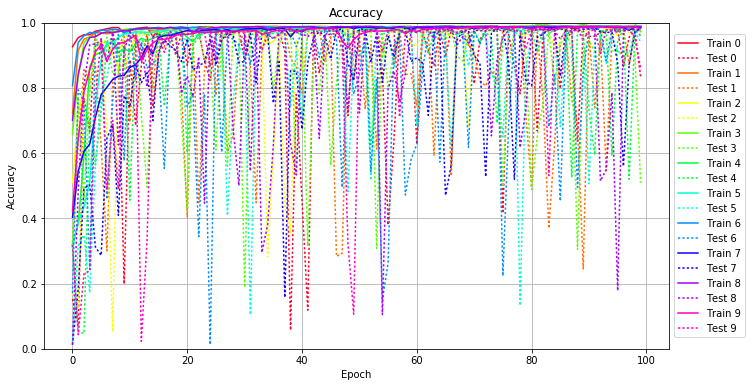

In [14]:
plot_acc(history)

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

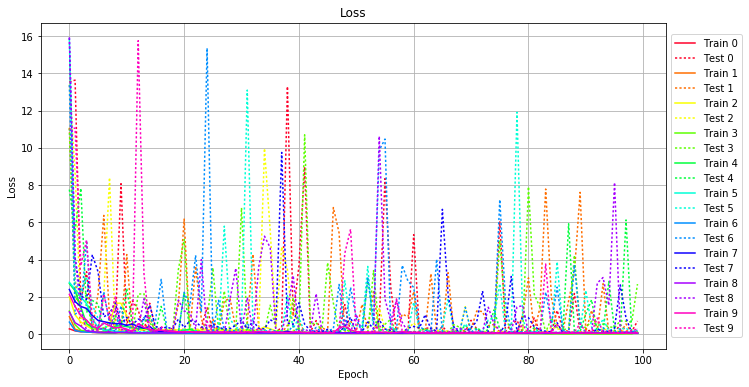

In [16]:
plot_loss(history)

Plotting the confusion matrix


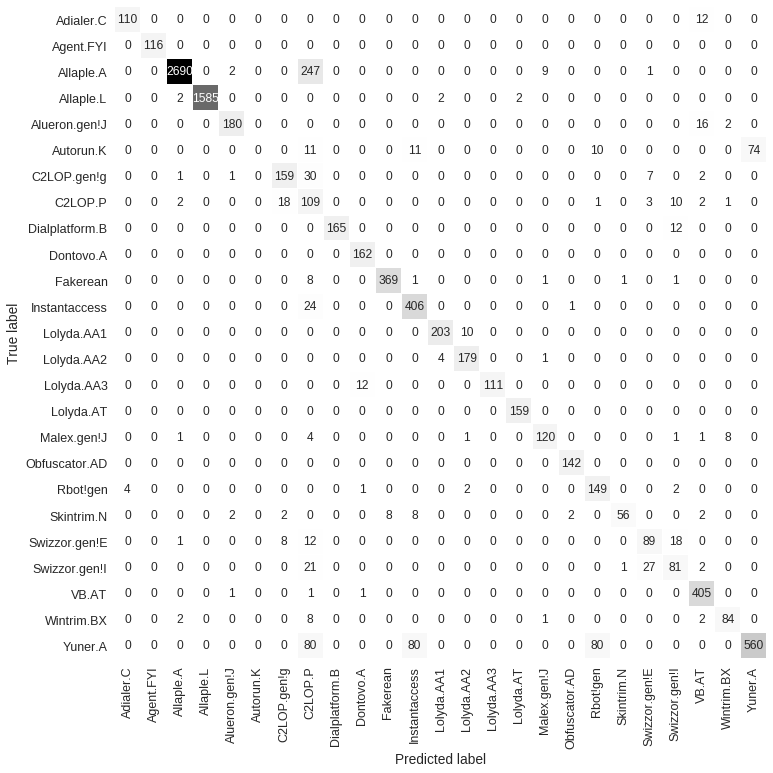

In [17]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


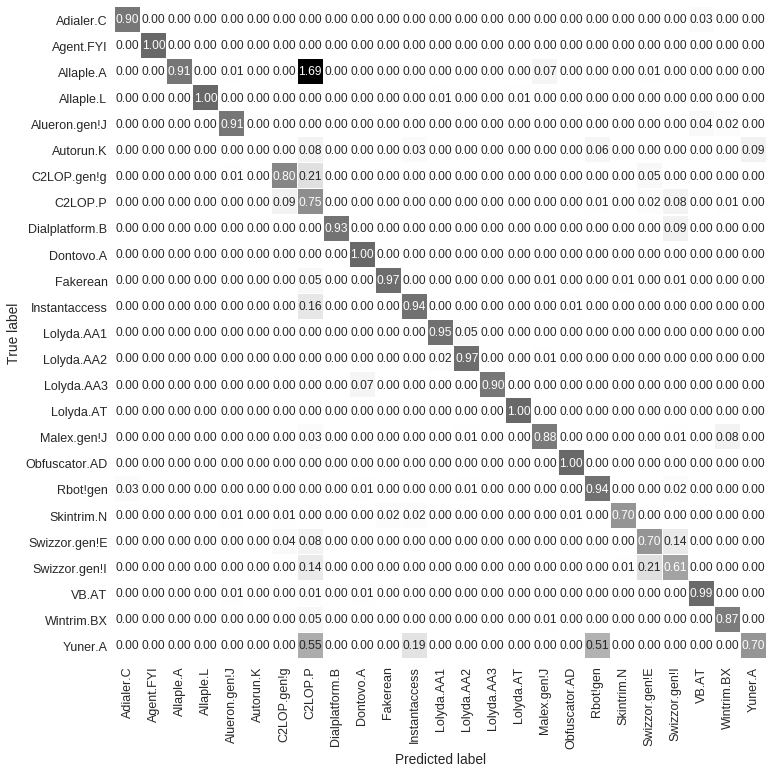

In [18]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
for h in history:
    print(h.history)

{'acc': [0.92613771741720274, 0.95413390518456154, 0.96294972596635475, 0.96306885870860137, 0.9739099356683345, 0.97736478436978791, 0.98141529664045746, 0.98475101262806763, 0.98475101262806763, 0.96974029069802348, 0.97533952824865489, 0.98224922563736006, 0.98403621634500837, 0.98618060516578288, 0.9575887538434098, 0.97807958062444378, 0.98010483678818205, 0.98320228736230753, 0.97939004051932443, 0.98117703118436761, 0.98165356206814391, 0.98272575649273286, 0.98701453416268548, 0.98653800333571595, 0.98713366690493209, 0.98463187991422441, 0.98570407431040996, 0.98427448177269483, 0.9849892780273507, 0.98522754348344055, 0.98749106504646178, 0.98641887062187272, 0.98832499404336427, 0.98832499404336427, 0.98808672861567781, 0.98832499401496088, 0.98796759590183469, 0.98772933047414824, 0.97379080292608788, 0.97748391705522775, 0.97891350964974977, 0.98153442935430069, 0.98546580891112701, 0.98653800332151431, 0.98081963304283792, 0.98534667616888028, 0.9849892780273507, 0.986895

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

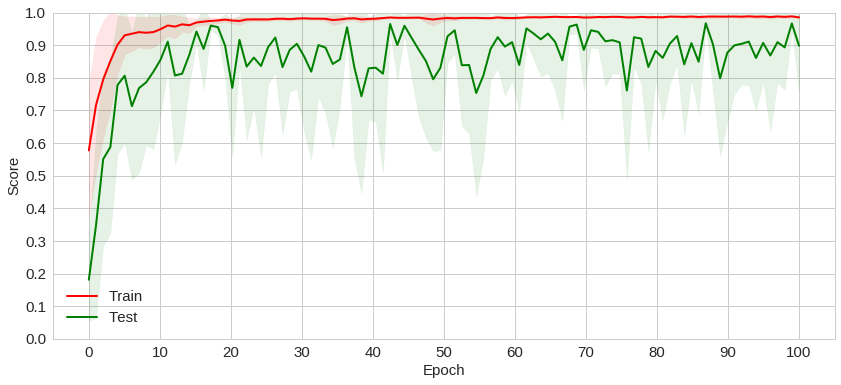

In [21]:
plot_mean_acc(history)

In [22]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

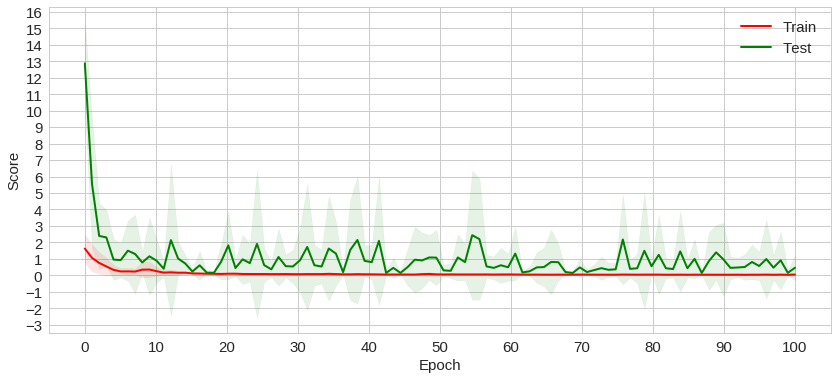

In [23]:
plot_mean_loss(history)

In [25]:
hist = [{'acc': [0.92613771741720274, 0.95413390518456154, 0.96294972596635475, 0.96306885870860137, 0.9739099356683345, 0.97736478436978791, 0.98141529664045746, 0.98475101262806763, 0.98475101262806763, 0.96974029069802348, 0.97533952824865489, 0.98224922563736006, 0.98403621634500837, 0.98618060516578288, 0.9575887538434098, 0.97807958062444378, 0.98010483678818205, 0.98320228736230753, 0.97939004051932443, 0.98117703118436761, 0.98165356206814391, 0.98272575649273286, 0.98701453416268548, 0.98653800333571595, 0.98713366690493209, 0.98463187991422441, 0.98570407431040996, 0.98427448177269483, 0.9849892780273507, 0.98522754348344055, 0.98749106504646178, 0.98641887062187272, 0.98832499404336427, 0.98832499404336427, 0.98808672861567781, 0.98832499401496088, 0.98796759590183469, 0.98772933047414824, 0.97379080292608788, 0.97748391705522775, 0.97891350964974977, 0.98153442935430069, 0.98546580891112701, 0.98653800332151431, 0.98081963304283792, 0.98534667616888028, 0.9849892780273507, 0.98689540144884225, 0.98403621634500837, 0.98618060516578288, 0.98534667616888028, 0.98820586130111765, 0.98820586130111765, 0.98475101259966424, 0.98558494159656673, 0.98165356206814391, 0.98272575649273286, 0.98749106501805828, 0.98772933047414824, 0.98820586132952104, 0.98344055277579223, 0.98784846315958796, 0.98725279963297707, 0.98510841076959732, 0.98784846318799147, 0.9884441267572075, 0.98820586132952104, 0.98772933047414824, 0.98808672861567781, 0.98820586130111765, 0.98320228734810577, 0.98546580891112701, 0.98701453419108887, 0.98832499401496088, 0.98856325947105073, 0.98641887067867962, 0.97593519181787103, 0.98451274717197779, 0.98618060519418638, 0.98772933047414824, 0.98832499404336427, 0.98784846318799147, 0.98796759590183469, 0.9884441267572075, 0.98808672862987956, 0.98010483675977855, 0.98641887063607447, 0.98272575654953986, 0.9828448891781727, 0.98737193233261855, 0.9876101977887084, 0.97998570404593532, 0.98629973790802949, 0.98761019776030501, 0.98808672858727442, 0.98856325947105073, 0.98772933047414824, 0.98772933047414824, 0.98832499404336427, 0.98701453419108887], 'loss': [0.27484384918492666, 0.16639301958384048, 0.11499845968816347, 0.13121156268885142, 0.084785031784509579, 0.068211033480978164, 0.057693700370247201, 0.048849728564676967, 0.051662534608467724, 0.11785554730000312, 0.091450398766997315, 0.057513346380319144, 0.049292298456778662, 0.048439162187074121, 0.15149350406649512, 0.067993361647565906, 0.06934200159624869, 0.055841626220866275, 0.069543515878587731, 0.060077470490939283, 0.062953010570699047, 0.053903730103756264, 0.042773760874725279, 0.043714629907816938, 0.041963415631786086, 0.052392421858569384, 0.04667200273080812, 0.05104245171896192, 0.048067198845710757, 0.048731332382532085, 0.041857798901791088, 0.044458217320625118, 0.037822898548324532, 0.03719165674531142, 0.038433924328455021, 0.037690108176431744, 0.039691968538618873, 0.039109136343618317, 0.093685888366412909, 0.07352422745505599, 0.074082190231241463, 0.059981934578895342, 0.04760350718537746, 0.043539770672704481, 0.0652915759046276, 0.04618136803820385, 0.049601011643927807, 0.043943806758431389, 0.05259640519288656, 0.042479550638581165, 0.046269322024098683, 0.037422234175182222, 0.037531742768853453, 0.048290164423593886, 0.045705209021301874, 0.058072773414387262, 0.056202011160270245, 0.039728606633676895, 0.03885993125169674, 0.037484649914075623, 0.052858185673685963, 0.040109407293397473, 0.041448438784637026, 0.050577712654250845, 0.040191503901150873, 0.037211607983222685, 0.038147868744341965, 0.039642835652599594, 0.03774746877883365, 0.038170470898069596, 0.051919663660467907, 0.047155396801579104, 0.040470953500628369, 0.037960285908030647, 0.03646882668480167, 0.049225291481771044, 0.084922086295696392, 0.052479574641655292, 0.044316685272787676, 0.038366384574802175, 0.03670130985881534, 0.039971679557203155, 0.037390459001695388, 0.036532486449640397, 0.04023322271889225, 0.064147258331399601, 0.044649850837185125, 0.061317556966180485, 0.055569136841455639, 0.041669100823006462, 0.040126956383302034, 0.071976558428478721, 0.043055610761866557, 0.038679576620250081, 0.037111452885623598, 0.037486976406907353, 0.037588959187779589, 0.039776495641218587, 0.037383541528713371, 0.042540384020699838], 'val_acc': [0.15238095238095239, 0.07407407407407407, 0.76931216931216928, 0.66560846560846565, 0.97142857142857142, 0.96931216931216935, 0.96613756613756618, 0.97671957671957677, 0.8666666666666667, 0.19894179894179895, 0.88571428571428568, 0.68465608465608463, 0.86878306878306877, 0.96719576719576716, 0.74179894179894179, 0.89735449735449735, 0.97460317460317458, 0.96507936507936509, 0.90052910052910051, 0.96931216931216935, 0.86878306878306877, 0.97566137566137567, 0.97460317460317458, 0.8835978835978836, 0.82222222222222219, 0.97142857142857142, 0.95343915343915342, 0.95661375661375658, 0.97354497354497349, 0.97671957671957677, 0.88571428571428568, 0.97671957671957677, 0.97777777777777775, 0.97671957671957677, 0.97777777777777775, 0.97883597883597884, 0.97883597883597884, 0.91111111111111109, 0.057142857142857141, 0.77989417989417986, 0.45291005291005293, 0.11851851851851852, 0.97460317460317458, 0.84444444444444444, 0.96084656084656084, 0.96507936507936509, 0.96613756613756618, 0.96931216931216935, 0.71534391534391539, 0.97354497354497349, 0.97566137566137567, 0.97777777777777775, 0.97989417989417993, 0.97460317460317458, 0.85608465608465611, 0.3798941798941799, 0.63492063492063489, 0.97566137566137567, 0.97142857142857142, 0.97671957671957677, 0.62751322751322747, 0.96931216931216935, 0.91640211640211644, 0.86772486772486768, 0.97777777777777775, 0.89417989417989419, 0.97883597883597884, 0.96931216931216935, 0.97354497354497349, 0.96719576719576716, 0.8126984126984127, 0.94814814814814818, 0.97566137566137567, 0.97671957671957677, 0.97989417989417993, 0.41587301587301589, 0.96613756613756618, 0.86455026455026451, 0.78201058201058204, 0.97460317460317458, 0.97883597883597884, 0.66772486772486772, 0.96931216931216935, 0.97777777777777775, 0.97671957671957677, 0.79788359788359786, 0.946031746031746, 0.97248677248677251, 0.63597883597883598, 0.97460317460317458, 0.95767195767195767, 0.95873015873015877, 0.96931216931216935, 0.97671957671957677, 0.97777777777777775, 0.97883597883597884, 0.8656084656084656, 0.9555555555555556, 0.97460317460317458, 0.83386243386243386], 'val_loss': [13.537122155245019, 13.635396119778749, 1.7921385133097862, 3.3433511840975991, 0.097878775118837316, 0.095260787802076918, 0.10349114020685352, 0.12074000598601295, 0.35449399010639154, 8.0720505406616851, 0.46318082328708399, 1.7803055768290525, 1.2945924565682074, 0.12791102768315657, 1.6490239009655341, 0.25611626565771761, 0.10160405535211481, 0.11724351108595901, 0.31734887030315662, 0.099893830165700623, 0.29569701730056847, 0.097369099133919002, 0.10165213245446375, 0.33890324694069229, 1.4147812405369544, 0.099404478823248252, 0.27632714123415847, 0.22963940393399263, 0.10177717459476987, 0.081697737336067597, 0.35998643815182346, 0.086432379604333878, 0.075764885848419186, 0.083539890068587502, 0.076789876491315828, 0.080952658692356197, 0.090007193351456891, 0.37032433467764386, 13.293619719005767, 0.96851547122457149, 3.6466518564829751, 8.9768285488956181, 0.10930672110891138, 0.71838161858025362, 0.15697973012328953, 0.14346705153260333, 0.11776070847156304, 0.098677632302264021, 1.5764306735814051, 0.095661067421269036, 0.078854141347898699, 0.07348952303827179, 0.072966932530652173, 0.089057125719067043, 0.66707461727090134, 8.343494322438719, 2.5057526902546958, 0.085700228489348246, 0.10228765215995726, 0.086884453481152327, 5.3359050913302415, 0.12430145860225869, 0.29216272689047312, 0.35002148151411566, 0.086902503227747965, 0.39718302296395736, 0.096919474359072014, 0.16033808313749187, 0.12559280563945269, 0.13773486898847359, 0.73578972438546153, 0.26077312818697895, 0.088554328790784106, 0.086746938619824257, 0.093733805197869655, 6.0491438567953768, 0.12926655791739788, 0.52813731442998957, 0.72222963465998569, 0.1039973065153775, 0.10140257622931935, 0.87142308789586265, 0.099765358768433093, 0.10282365717341534, 0.11004001428448998, 1.2638832432470746, 0.2136902412113231, 0.13739107789988531, 2.1749122052596435, 0.1138657553798381, 0.16391704148716396, 0.19557750500378981, 0.12969568476386409, 0.10936597057363504, 0.1018559489396115, 0.10781136908280176, 0.49313186656624552, 0.17386018476158221, 0.12520496419193, 0.69510962918952657]},
{'acc': [0.72156722648975413, 0.91532690257164107, 0.94938668583466412, 0.95569846373704892, 0.96998928199286294, 0.96748838880963017, 0.96629748730428366, 0.96725020840776466, 0.97618196975110161, 0.97904013348034591, 0.97665833035607952, 0.97820650232225792, 0.98035012514403541, 0.98213647731332621, 0.9741574372793218, 0.97987376453905739, 0.97963558423656838, 0.9818982970108372, 0.98380373953012568, 0.98428010014220191, 0.97463379788429971, 0.97832559247350248, 0.98368464927950461, 0.98487555089132606, 0.98582827210838031, 0.98320828867452659, 0.98630463260688339, 0.98690008349087577, 0.97272835547148617, 0.97987376443968088, 0.98559009169941647, 0.98356555923473499, 0.97927831378993324, 0.97689651075794515, 0.98582827200190548, 0.9865428129093724, 0.98618554255501545, 0.98761462427057278, 0.9876146243699494, 0.9865428129093724, 0.9865428129093724, 0.98785280457306179, 0.98821007502679525, 0.98844825532928426, 0.98821007502679525, 0.98725735381683932, 0.98285101832016974, 0.98428010004992372, 0.98046921519590335, 0.986066452403771, 0.98582827211547863, 0.98070739549839225, 0.98701917361372693, 0.98642372285750446, 0.98618554245563894, 0.98642372285750446, 0.986066452403771, 0.98785280457306179, 0.98809098497492731, 0.98487555089132606, 0.9865428129093724, 0.98773371452119385, 0.98773371452119385, 0.98273192806954868, 0.98749553411932833, 0.98797189482368286, 0.98523282124568301, 0.98690008336310586, 0.9876146243699494, 0.98404191973323807, 0.98737644406746039, 0.98773371442181734, 0.98797189472430635, 0.98821007502679525, 0.98547100164754853, 0.98797189482368286, 0.9876146243699494, 0.98832916517803981, 0.98856734548052871, 0.98809098497492731, 0.98797189472430635, 0.98749553421870495, 0.98642372285750446, 0.98570918195003754, 0.98725735381683932, 0.98749553421870495, 0.98737644396808388, 0.98606645230439438, 0.98606645230439438, 0.98559009169941647, 0.98678099331123792, 0.98737644396808388, 0.98749553421870495, 0.98654281300874891, 0.98499464097158729, 0.98166011681482312, 0.98713826366559487, 0.98773371442181734, 0.98832916517803981, 0.98821007512617187], 'loss': [0.93046903486008781, 0.25558125936901255, 0.15773598447475773, 0.13497155540537037, 0.085485438136695555, 0.10134147780345028, 0.10687370013236659, 0.10709170170897626, 0.071592767383848691, 0.063060179329690755, 0.071974368702287086, 0.067843503831026525, 0.063884122596406592, 0.057469362564934172, 0.08912235772423735, 0.065884609062415833, 0.069438840525340814, 0.059958292338169725, 0.05206820628210606, 0.053224478647639899, 0.082477528395589736, 0.069397314220162903, 0.051109484248142788, 0.048820566082974623, 0.04663829050618324, 0.054375648676159676, 0.043989941220461251, 0.046043393731727701, 0.092197367658611709, 0.062510667226137656, 0.047081752776845842, 0.052269786117161203, 0.070343322802600763, 0.07362462888448823, 0.046496270351112777, 0.043463045629924806, 0.04368448240410306, 0.040126705943927664, 0.039970195618529852, 0.043182726591986083, 0.041212468428123109, 0.038554267798316069, 0.037991747537593878, 0.036726137884498009, 0.036994440550497207, 0.040347585877155395, 0.054227349303003519, 0.048206217556826282, 0.063914597470945952, 0.044402950064786999, 0.049462980106854501, 0.065846695021554394, 0.041996087374961334, 0.044194355054250629, 0.044403313356121729, 0.044235841818646301, 0.0450904830985017, 0.038984328900670509, 0.037722959377140437, 0.048533332628963588, 0.044647131849431247, 0.040059656067144109, 0.038928401900342892, 0.054639568185923755, 0.040295735349825654, 0.038263288664508323, 0.047289577433106314, 0.041098315502944266, 0.039930379987330865, 0.050054828456205694, 0.039332315109238049, 0.039059193559080572, 0.038055025096115393, 0.037074055548411713, 0.047115119299896278, 0.037881932008957828, 0.037895559955810211, 0.037021289287097074, 0.036388330402914594, 0.038506299537662325, 0.038810973753404004, 0.038760852134765808, 0.042552444909503946, 0.04523699035264913, 0.04039923936515475, 0.038813694873224683, 0.040869907890705465, 0.046739158856665734, 0.04139882155070302, 0.04700933773737373, 0.041381061797598026, 0.039161651940501467, 0.040013185708142614, 0.04230842175470359, 0.050807227616482181, 0.06420171103250899, 0.041193416087486792, 0.03793700099655975, 0.037101973792919803, 0.037348764275204102], 'val_acc': [0.31316348195329086, 0.63481953290870485, 0.85987261146496818, 0.82059447983014866, 0.87048832271762211, 0.62101910828025475, 0.30042462845010615, 0.81740976645435248, 0.92569002123142252, 0.96390658174097665, 0.69532908704883223, 0.97239915074309979, 0.9002123142250531, 0.96390658174097665, 0.79830148619957542, 0.97558386411889597, 0.92569002123142252, 0.97239915074309979, 0.97983014861995754, 0.78980891719745228, 0.40339702760084928, 0.96709129511677283, 0.44798301486199577, 0.85562632696390661, 0.95859872611464969, 0.77707006369426757, 0.97876857749469215, 0.60297239915074308, 0.65286624203821653, 0.93099787685774948, 0.97558386411889597, 0.87048832271762211, 0.44798301486199577, 0.91295116772823781, 0.97770700636942676, 0.97452229299363058, 0.97558386411889597, 0.98407643312101911, 0.88959660297239918, 0.86518046709129515, 0.78450106157112531, 0.97452229299363058, 0.97770700636942676, 0.98089171974522293, 0.88004246284501064, 0.96072186836518048, 0.28343949044585987, 0.2929936305732484, 0.97770700636942676, 0.82590233545647562, 0.95541401273885351, 0.73460721868365175, 0.93312101910828027, 0.61252653927813161, 0.97983014861995754, 0.97876857749469215, 0.87048832271762211, 0.97664543524416136, 0.84076433121019112, 0.8428874734607219, 0.74734607218683646, 0.97770700636942676, 0.97770700636942676, 0.59129511677282376, 0.97770700636942676, 0.97664543524416136, 0.52972399150743099, 0.97876857749469215, 0.98195329087048833, 0.92993630573248409, 0.90870488322717624, 0.82165605095541405, 0.80573248407643316, 0.85350318471337583, 0.82165605095541405, 0.97770700636942676, 0.97664543524416136, 0.98089171974522293, 0.97876857749469215, 0.71974522292993626, 0.49469214437367304, 0.97027600849256901, 0.7579617834394905, 0.36942675159235666, 0.62526539278131632, 0.93418259023354566, 0.96178343949044587, 0.76326963906581746, 0.69108280254777066, 0.24522292993630573, 0.96815286624203822, 0.73885350318471332, 0.95222929936305734, 0.54564755838641188, 0.96178343949044587, 0.97239915074309979, 0.98089171974522293, 0.87048832271762211, 0.98195329087048833, 0.97983014861995754], 'val_loss': [11.070496561167856, 2.9471035066064202, 0.4297546490931986, 0.72615329923074601, 0.27535679553057946, 2.1577356394752067, 6.3684913165503501, 0.91523073139084377, 0.32750084357644627, 0.10247891651478662, 4.2673319777653749, 0.072560650506030971, 0.41318993574830554, 0.12880626438501572, 0.87321874394918331, 0.074337073227298364, 0.19901313990260816, 0.10328891339312116, 0.067293980854885721, 1.601563436178898, 6.1709922824189443, 0.10538115524222394, 3.642089636021387, 0.79325156511144213, 0.12779824533564041, 0.78669328694619856, 0.083877008044728349, 1.7718856954144317, 1.9119686205296, 0.26648901015393545, 0.081732808481062985, 0.59567024743548258, 4.2801394701522337, 0.34588551651014138, 0.06445627569760648, 0.071831765078288895, 0.086266676172683424, 0.059052725231673313, 0.46076752489203199, 1.0862140682101886, 0.68481554547984291, 0.094505475653302584, 0.072454665271438679, 0.059968173350516775, 0.36550869385196755, 0.13901925730801762, 6.7911012643461772, 5.4319156446274679, 0.082020068502191235, 0.70279185659788157, 0.14888220775532368, 1.5894399705187785, 0.24673024887174302, 2.2663516889775148, 0.066488095630690011, 0.062867731163619392, 0.30072838060129997, 0.087175682326231144, 1.0631689718151327, 0.92964836420400376, 2.2749543532779679, 0.090810014739374514, 0.095735424628235172, 3.2396625579673328, 0.078127572595464087, 0.080099076045987455, 3.2890460496242384, 0.079189809481819182, 0.073114847158450458, 0.22722446200321181, 0.26164166746338391, 1.2373051813313931, 1.2064123126557551, 0.44713864959268784, 0.51177497683567508, 0.086334289991074314, 0.090418818804206019, 0.073298091290101827, 0.088541925584712772, 1.0308929058451184, 3.0131360290742841, 0.11644844327261869, 1.4062825517500048, 7.7856556210042074, 1.9492261374958528, 0.46347020727962118, 0.13550805338043637, 1.7925720157263891, 3.2863991528812759, 7.6064250737491941, 0.14061455595301614, 1.2647787865444, 0.1916901418136456, 2.6968122713758182, 0.12687076637946898, 0.13980289723515962, 0.06661919515452594, 0.53803024892477447, 0.067416111705040749, 0.070805476010734295]},
{'acc': [0.50993929296260132, 0.71812879433306664, 0.80216640880343149, 0.85644566125209065, 0.92500892752991482, 0.94334007858336077, 0.93381740269725089, 0.90382097382131699, 0.86323056780373875, 0.86989644092117768, 0.91227234852993688, 0.96667063444827994, 0.96702773482185678, 0.96678966802438804, 0.97036067134864901, 0.969646470785964, 0.97321747423793403, 0.97607427687180093, 0.97440780859421494, 0.97762171170808287, 0.97774074515648191, 0.98154981549815501, 0.97964528032377096, 0.97952624689665679, 0.97369360790382098, 0.97821687895717291, 0.97893107976108606, 0.98250208309244191, 0.98047851446256395, 0.98476371860492795, 0.98297821687894293, 0.98404951804224305, 0.98547791929532202, 0.97702654445899295, 0.93441257005986, 0.94191167720257274, 0.96464706582549697, 0.96631353410308296, 0.96559933342687887, 0.97083680526995397, 0.97464587551939275, 0.97595524342340201, 0.97952624687537193, 0.97976431378635986, 0.982978217006652, 0.98202594929175102, 0.98154981562586396, 0.98428758481133194, 0.98357338412093798, 0.98476371860492795, 0.98523985240561895, 0.97190810630554503, 0.98012141411736697, 0.98107368171165388, 0.98047851446256395, 0.98190691585754186, 0.98226401618854897, 0.98190691584335199, 0.980240447565766, 0.97785977859778594, 0.98166884894655393, 0.98381145101773604, 0.98547791929532202, 0.98416855136293302, 0.98678728722771103, 0.98666825379350187, 0.98619212011342505, 0.98547791929532202, 0.98762052136650402, 0.98393048459384402, 0.98154981549815501, 0.98678728735541998, 0.98226401631625804, 0.98607308653731696, 0.98595405309601292, 0.98226401618854897, 0.98535888584692299, 0.98559695274372094, 0.98714438757290801, 0.98726342102130704, 0.98809665516010003, 0.98821568873620802, 0.987977621711701, 0.98845375550529702, 0.98785858826330197, 0.98143078206394585, 0.98166884894655393, 0.98571598619211998, 0.98678728723480591, 0.98750148791810499, 0.98857278895369594, 0.98845375550529702, 0.98845375563300597, 0.978693012864288, 0.98464468516362391, 0.98190691585044698, 0.98607308653731696, 0.98654922033091297, 0.98821568873620802, 0.98714438757290801], 'loss': [1.9992508063669958, 1.0260657300098839, 0.64612628147582496, 0.43849989054189126, 0.25654378189613186, 0.21972018347625405, 0.32734973153079239, 0.46041811185143644, 1.6549692039702026, 1.6509817932464015, 0.96016971614229973, 0.24768980390172413, 0.23765320171842744, 0.24271709334476407, 0.23592271552300428, 0.22985387282837802, 0.22567325843851305, 0.21640909439831468, 0.22052274718339665, 0.21562452880633953, 0.20994175267046072, 0.20114958094860422, 0.20358245890677529, 0.20643125555601421, 0.22747589919861122, 0.21225259042659936, 0.20875610871097044, 0.19861299756977788, 0.2053270964903666, 0.19641490331154754, 0.19664883850904069, 0.19719055489392071, 0.19232299287316407, 0.2174827980118556, 0.38126735079006102, 0.27531357714568216, 0.16163471005885813, 0.15490390023212391, 0.13944505846311672, 0.10264156222762047, 0.10168182582049806, 0.083244651566657432, 0.073350794619569434, 0.069122520816736227, 0.05866271924857596, 0.06193630003461581, 0.060984574269856769, 0.054783404173537664, 0.054009832110339766, 0.046686457070497511, 0.055445472458518268, 0.1066875433782753, 0.082906389726710994, 0.091171775984772607, 0.088277761398884685, 0.065955984897165698, 0.066502975672217385, 0.060408956487094941, 0.071759080310775519, 0.076268323006611918, 0.064086737640615773, 0.055653440949285676, 0.047158991075886343, 0.047054142225921726, 0.04250066332654745, 0.045493426432624884, 0.045424768279711557, 0.047132359212558192, 0.041539997432889532, 0.058855320884491517, 0.061545879152609985, 0.043803434945361812, 0.057514136507459769, 0.047023887199725181, 0.049193095418047783, 0.07591266124643968, 0.04959904083310529, 0.052916194262055537, 0.043151094591204704, 0.042330854812918775, 0.041013311821333366, 0.036949001696972232, 0.039127042594001828, 0.03701224167366856, 0.037041806580303482, 0.059173269930119711, 0.059540569646566233, 0.052751882225913586, 0.044099240195870387, 0.041061661018280599, 0.03844224352659182, 0.037057919497593371, 0.03687200993086636, 0.076857649954340745, 0.060467035765840019, 0.065085546799875868, 0.04577654093741633, 0.044859749471655441, 0.037968431886229226, 0.045237659425813377], 'val_acc': [0.16950959488272921, 0.12260127931769722, 0.74413646055437099, 0.81556503198294239, 0.89978678038379534, 0.94562899786780386, 0.6652452025586354, 0.052238805970149252, 0.90298507462686572, 0.95522388059701491, 0.95522388059701491, 0.95948827292110872, 0.96055437100213215, 0.96162046908315568, 0.95735607675906187, 0.96055437100213215, 0.95415778251599148, 0.96801705756929635, 0.96375266524520253, 0.97228144989339016, 0.96695095948827292, 0.97014925373134331, 0.9733475479744137, 0.97014925373134331, 0.97121535181236673, 0.9733475479744137, 0.95202558635394452, 0.9733475479744137, 0.96162046908315568, 0.97547974413646055, 0.97441364605543712, 0.97228144989339016, 0.97014925373134331, 0.97228144989339016, 0.28144989339019189, 0.59808102345415781, 0.93923240938166308, 0.43390191897654584, 0.35607675906183367, 0.94349680170575689, 0.85181236673773986, 0.97121535181236673, 0.95948827292110872, 0.97228144989339016, 0.97228144989339016, 0.97654584221748397, 0.9658848614072495, 0.97441364605543712, 0.97654584221748397, 0.95842217484008529, 0.9733475479744137, 0.94456289978678043, 0.97441364605543712, 0.97441364605543712, 0.89445628997867799, 0.96375266524520253, 0.97547974413646055, 0.97228144989339016, 0.97014925373134331, 0.93496801705756927, 0.92750533049040507, 0.97121535181236673, 0.96801705756929635, 0.96908315565031988, 0.96801705756929635, 0.97654584221748397, 0.95735607675906187, 0.97441364605543712, 0.97761194029850751, 0.6801705756929638, 0.97867803837953093, 0.97654584221748397, 0.97228144989339016, 0.9733475479744137, 0.97547974413646055, 0.97228144989339016, 0.97228144989339016, 0.97228144989339016, 0.97761194029850751, 0.95842217484008529, 0.97867803837953093, 0.97654584221748397, 0.97761194029850751, 0.97761194029850751, 0.92004264392324098, 0.93816631130063965, 0.94669509594882728, 0.97867803837953093, 0.97547974413646055, 0.97654584221748397, 0.97547974413646055, 0.97867803837953093, 0.97441364605543712, 0.94349680170575689, 0.96162046908315568, 0.96268656716417911, 0.97441364605543712, 0.96908315565031988, 0.97547974413646055, 0.96801705756929635], 'val_loss': [13.385923601162714, 8.6656702362906444, 0.90594137509240269, 0.53779982643595126, 0.30040237491827276, 0.18671591196066217, 2.0552741938562535, 8.3939808843486592, 0.2793849738739701, 0.14748812983158047, 0.16710459350892254, 0.16039630878510189, 0.15174623127621628, 0.26664514297212599, 0.26195251887916515, 0.15593730805934206, 0.18801913763536601, 0.14801746312536793, 0.16196378769635011, 0.13984341154903618, 0.26162740409842011, 0.25095358080189079, 0.24329469197028719, 0.2715412840418408, 0.24927931053888999, 0.25534008192364627, 0.32380890772382886, 0.13220263539608926, 0.18105420115263016, 0.24737379511000282, 0.25582461023623698, 0.13075072431426685, 0.13776406234499397, 0.25201756546699899, 9.9622703015423024, 5.5498665022189178, 0.35204301985786923, 4.6792412617567507, 3.4562346818350527, 0.18849799454709623, 0.29920828938048566, 0.1012578859115079, 0.1403531951268594, 0.10948763741826062, 0.10258302256278297, 0.095694512347512042, 0.11569250197803128, 0.096773523069582562, 0.091100489707236221, 0.18182959014436664, 0.10359988524760023, 0.17588154001753215, 0.094741462069729374, 0.096209577337003693, 1.3867197976147791, 0.24331723728142035, 0.098923243650423945, 0.11077268305504938, 0.11807226803296161, 0.2774784521831235, 0.59333632052836338, 0.22312737807188668, 0.22131649398180131, 0.17441968788538795, 0.21268933776791876, 0.10751744566995626, 0.16072087874403637, 0.10138969943582177, 0.098955704552704277, 1.4687947009418056, 0.10448684404445691, 0.10016110749443322, 0.13393368374097622, 0.11482854691754306, 0.10423479418638028, 0.11742079989321387, 0.11259034006826972, 0.11398211535712875, 0.096867125331459497, 0.34396832420145407, 0.091950855709908741, 0.089112554539502883, 0.098034952855113724, 0.10259184768701723, 0.38315180564242024, 0.27386646914445528, 0.21058657387312413, 0.095972220746994907, 0.10606057198565551, 0.10225161804068356, 0.11488128546654076, 0.091967719951553936, 0.12271963161732242, 0.28905739685668347, 0.17087499808067325, 0.15580645310927638, 0.14724874661644366, 0.15394219857912242, 0.10488195720044809, 0.14839661511174346]},
{'acc': [0.65702725210091084, 0.83327383077472328, 0.9385933595144591, 0.95775318341525861, 0.95703915268356543, 0.96691657741282877, 0.97036772586186271, 0.97417588966255686, 0.97120076168240299, 0.97834106866595261, 0.98167321194811374, 0.98000714035668601, 0.97750803284541232, 0.98107818637620003, 0.98048316082556619, 0.9651315007538338, 0.97715101754340505, 0.98274425800309417, 0.98536237058193499, 0.98238724270108679, 0.98155420688054651, 0.98548137569915506, 0.98476734499583485, 0.98381530405807449, 0.98655242175413538, 0.97667499702487204, 0.98488635011305481, 0.98607640133490804, 0.98667142687135545, 0.98714744738988847, 0.98167321194811374, 0.97643698671949941, 0.9746519100817842, 0.98500535532958056, 0.98524336546471503, 0.98631441151969534, 0.98560038081637513, 0.98667142687135545, 0.98536237058193499, 0.98726645250710843, 0.98571938593359509, 0.98214923241699392, 0.98524336546471503, 0.98548137569915506, 0.98571938603290077, 0.97810305843151257, 0.98571938593359509, 0.98643341665110196, 0.98381530410772733, 0.98607640133490804, 0.98809948832764871, 0.98833749851243602, 0.98809948827799599, 0.98619540640247527, 0.98655242175413538, 0.98655242185344105, 0.97096275144796296, 0.98560038081637513, 0.98798048316077591, 0.98798048316077591, 0.98786147804355584, 0.98679043208788109, 0.98607640128525531, 0.98774247292633588, 0.98845650367930893, 0.98833749851243602, 0.9872664524574557, 0.98512436034749495, 0.98595739618222178, 0.97905509936927293, 0.98726645250710843, 0.98809948827799599, 0.98857550879652889, 0.98726645255676126, 0.98786147809320868, 0.98643341663691542, 0.98714744738988847, 0.98702844222301556, 0.98857550874687616, 0.98857550874687616, 0.98833749851243602, 0.99476377489197099, 0.99226466743035013, 0.99654885160061879, 0.99892895394501968, 0.99726288230393911, 0.99940497441389975, 1.0, 0.99726288240324468, 0.99369272878733783, 0.99797691300725933, 0.99940497441389975, 0.99964298464833989, 0.99988099488277993, 1.0, 0.99964298464833989, 0.99952397953111982, 0.99738188742115907, 0.99750089246744655, 0.97250981797182345], 'loss': [1.2296601028211427, 0.49323289384341701, 0.19876062686531923, 0.13584174462106985, 0.13215086966270664, 0.10122072079483702, 0.086551197671179511, 0.081312176763592883, 0.088387719246797239, 0.067828893038179003, 0.058436566527334831, 0.060265277991277268, 0.068731017094661853, 0.060119547599783177, 0.063414387347285953, 0.10832914519945554, 0.077710574576822927, 0.055158646828698345, 0.046491873438496555, 0.062961942190309941, 0.060751832852289252, 0.044746244340642047, 0.04811686719033486, 0.051245936515093682, 0.044168499635434302, 0.076148719314140439, 0.050445621433101155, 0.045468255513965355, 0.042182969415076474, 0.040853236798486528, 0.059885489389408519, 0.078442343839304679, 0.08262987588167077, 0.048999348763736898, 0.047271312231169801, 0.046769289735416053, 0.047197519876368769, 0.042055409386914523, 0.046459904533842945, 0.041050016202629283, 0.046497746853628473, 0.05967918908777449, 0.046369322130194339, 0.046286786438155342, 0.045001080580428995, 0.071417020999341163, 0.045766811844068542, 0.044060497419133038, 0.050989842361301864, 0.042960694357424736, 0.036869274828936337, 0.036814131171524697, 0.036993969627847227, 0.04336167841362383, 0.042518040773219495, 0.043581487019757469, 0.10618432298059706, 0.044124308065170474, 0.037775977780958446, 0.038708333696761715, 0.039606204945791354, 0.041798851714664222, 0.046381242957627168, 0.038490445974318832, 0.037133304100547049, 0.036334002245646257, 0.041259979908769645, 0.048976637242492904, 0.046925977289173047, 0.063033248956767304, 0.03978434433812799, 0.038201905192265788, 0.036300978355892612, 0.041740846963038293, 0.038721821315105112, 0.043261536661762488, 0.040096452863786984, 0.040033822746002673, 0.035796443563352327, 0.0357905331858085, 0.033889425044991699, 0.018199593756318747, 0.026111692895727769, 0.013486605456644651, 0.0033215013617004852, 0.015707279820436886, 0.0034414386238420022, 0.00046598360931377657, 0.0092925737189900603, 0.020532562793562227, 0.0080877130406823462, 0.0054565783054121774, 0.0014159561719504033, 0.0006468012290237015, 0.00017639457054686853, 0.0059667262812276387, 0.0020129374035549145, 0.012476900943616269, 0.010577335593771196, 0.10132446372443744], 'val_acc': [0.31517094017094016, 0.77029914529914534, 0.45405982905982906, 0.77991452991452992, 0.95619658119658124, 0.91346153846153844, 0.95512820512820518, 0.84294871794871795, 0.84722222222222221, 0.96901709401709402, 0.95299145299145294, 0.9786324786324786, 0.71581196581196582, 0.49572649572649574, 0.86645299145299148, 0.94123931623931623, 0.96688034188034189, 0.97435897435897434, 0.97222222222222221, 0.69978632478632474, 0.42200854700854701, 0.97008547008547008, 0.96153846153846156, 0.88782051282051277, 0.87286324786324787, 0.6100427350427351, 0.94123931623931623, 0.55982905982905984, 0.98397435897435892, 0.97970085470085466, 0.18803418803418803, 0.95192307692307687, 0.95192307692307687, 0.97329059829059827, 0.98183760683760679, 0.79380341880341876, 0.93162393162393164, 0.9850427350427351, 0.98183760683760679, 0.5395299145299145, 0.95512820512820518, 0.31517094017094016, 0.89423076923076927, 0.78311965811965811, 0.9604700854700855, 0.56303418803418803, 0.81623931623931623, 0.98076923076923073, 0.95512820512820518, 0.97970085470085466, 0.9850427350427351, 0.98290598290598286, 0.97970085470085466, 0.30769230769230771, 0.96581196581196582, 0.79914529914529919, 0.91239316239316237, 0.98183760683760679, 0.97329059829059827, 0.98611111111111116, 0.96901709401709402, 0.98397435897435892, 0.98183760683760679, 0.96474358974358976, 0.98397435897435892, 0.94978632478632474, 0.9786324786324786, 0.89743589743589747, 0.88247863247863245, 0.96153846153846156, 0.97970085470085466, 0.97649572649572647, 0.98290598290598286, 0.97756410256410253, 0.98290598290598286, 0.50320512820512819, 0.85576923076923073, 0.98397435897435892, 0.98290598290598286, 0.8995726495726496, 0.48824786324786323, 0.65491452991452992, 0.75320512820512819, 0.9754273504273504, 0.8108974358974359, 0.94658119658119655, 0.98076923076923073, 0.91025641025641024, 0.30448717948717946, 0.90384615384615385, 0.94230769230769229, 0.91346153846153844, 0.90918803418803418, 0.91132478632478631, 0.91346153846153844, 0.91346153846153844, 0.8963675213675214, 0.90705128205128205, 0.90384615384615385, 0.50961538461538458], 'val_loss': [11.038140150216913, 1.7179601410245331, 2.4108090242928166, 2.1258757109318309, 0.10923290685983593, 0.34705128558935749, 0.14537883626469253, 0.74492100759362678, 0.60155403970654342, 0.086985447569009208, 0.20559270324224793, 0.066574975557289834, 2.1397063667464575, 2.1644683016671076, 0.59399536686639187, 0.25162617715773972, 0.112517964027219, 0.14382548994566097, 0.10874907189232975, 3.4740330619502715, 5.0761431155743226, 0.099320390141731205, 0.12264668369831409, 0.17787506936468211, 0.65967612572533818, 3.5598018056350891, 0.2071165891895797, 2.3108101062094573, 0.074173716317768285, 0.10222572967900383, 6.7783405225501099, 0.21719922316651816, 0.21581599334011964, 0.087465202849011409, 0.098427327891193697, 1.5486324271585208, 0.26581543085114162, 0.053707849724645727, 0.069550317632154815, 1.9421070204852715, 0.20783577413640664, 10.696834547906862, 0.50366416341392861, 0.61390376576117012, 0.15733063557686713, 3.8283556148282485, 1.6641315373026917, 0.077678910542483839, 0.25139754184702923, 0.10570361769066106, 0.055656674363386338, 0.062925854596994957, 0.062004917517162896, 3.4042809861911159, 0.1267620627130778, 0.52295592950866054, 0.78854268676159855, 0.055065204952678574, 0.080112726855963379, 0.048668429547891967, 0.13664553446779659, 0.062840225460503357, 0.063541741460628354, 0.12416441250233469, 0.05895950203741477, 0.17247979576091488, 0.10610631095498212, 0.49607142837893542, 0.36293686844312056, 0.11974994683225662, 0.06480036164324969, 0.068048168937976647, 0.074967153271621526, 0.070079219293576051, 0.065716297896442399, 5.0321469794308102, 0.96323222607315984, 0.055690307935682908, 0.058786386946849234, 0.1573728276844841, 7.909020045242853, 2.143548181704614, 1.4256852649002401, 0.087290646300570943, 0.85530205677526117, 0.33944021053809426, 0.21716684041785078, 0.30311744214612418, 4.2210461502401238, 0.37279991965052378, 0.35577297739018116, 0.68322704100836373, 0.46729167823972462, 0.53252927800318328, 0.38127345568089244, 0.34968812460831544, 0.69912656954855068, 0.68951185109197055, 0.63513044452171619, 2.679830997545495]},
{'acc': [0.31675392671575553, 0.38374583531651596, 0.59007615426901916, 0.86470728227491889, 0.90111851496449091, 0.90897191824770041, 0.93336506422674692, 0.94288434073336069, 0.90873393624921683, 0.92027605901951448, 0.91087577338447911, 0.93384102802512647, 0.95228462631165667, 0.9443122322419778, 0.95276059013840586, 0.95787720130432907, 0.96477867676382234, 0.96335078531194451, 0.96763445978105667, 0.97072822459818686, 0.95502141842894306, 0.94169443122322705, 0.96406473102369861, 0.96739647783931237, 0.97072822471166553, 0.97215611610680408, 0.97298905288872406, 0.97881960965292281, 0.97608281770585437, 0.97727272727272729, 0.97751070915773219, 0.97941456446472885, 0.98084245597334607, 0.98167539261341774, 0.98072346501665875, 0.98143741072841284, 0.98131841977172551, 0.98191337455516203, 0.98310328412203496, 0.98334126606377914, 0.98262732026691613, 0.98584007615421232, 0.98667301282265363, 0.98203236551184925, 0.9844121846455951, 0.98691099476439792, 0.98476915754402661, 0.98429319368890789, 0.98667301285102327, 0.98584007609747293, 0.98250832936696808, 0.9854831032557807, 0.97941456446472885, 0.98167539264178738, 0.98250832933859844, 0.98643503093764873, 0.98786292241789619, 0.98810090433127085, 0.98762494050452165, 0.98726796763445979, 0.98679200380771059, 0.98643503099438801, 0.98595906711089953, 0.98607805806758686, 0.98845787720133271, 0.98869585911470725, 0.98857686815802004, 0.98869585911470725, 0.98833888624464539, 0.98346025702046647, 0.98286530223702995, 0.98298429316534763, 0.98714897667777246, 0.98726796760609015, 0.98655402189433605, 0.9841742027605902, 0.98774393143283934, 0.98750594951946469, 0.98738695856277747, 0.98762494050452165, 0.9831032841504046, 0.98500713945740126, 0.98584007612584268, 0.9863160399809614, 0.98798191337458352, 0.98869585908633761, 0.98857686815802004, 0.98786292241789619, 0.98762494050452165, 0.98833888624464539, 0.98595906711089953, 0.98584007615421232, 0.98833888624464539, 0.98821989528795806, 0.98845787714459343, 0.97715373631603997, 0.98691099473602828, 0.98334126606377914, 0.98691099476439792, 0.98786292241789619], 'loss': [2.7091449912759815, 2.3165089194403552, 1.4400526196090793, 0.55476234093670163, 0.34457111789861333, 0.31075029552465167, 0.22421629738589233, 0.18340873956566819, 0.41820529289100355, 0.44334166683522591, 0.39444015679729377, 0.34263321406951353, 0.26865474383981952, 0.3087304808210044, 0.22167025348335603, 0.17245518152328515, 0.14650211613385919, 0.15471648090456508, 0.13738925067192809, 0.11571203142418741, 0.20478332479586775, 0.24746213131085543, 0.12982572591032429, 0.10421129847667944, 0.094376060457413452, 0.095266553109200555, 0.084018364956496949, 0.068130194509613801, 0.07148950307610942, 0.070829622560082753, 0.069184627637501162, 0.066307228099357962, 0.059514575762437502, 0.059203366508289841, 0.060291946054866687, 0.05833944120133621, 0.061141835124023977, 0.058557074330835783, 0.053977480795640485, 0.053899929730637425, 0.055238747117293555, 0.048280098975974281, 0.043142304090390257, 0.055601392244509662, 0.049293020207333824, 0.041672920374672281, 0.049029655367143092, 0.049355507641676094, 0.043343949082463994, 0.046102213255284456, 0.055070436061375454, 0.047872847645609562, 0.066985914734560559, 0.061737042074683508, 0.057530799166949691, 0.04381769303299643, 0.038976891653373771, 0.039267909803517742, 0.038563470165114466, 0.040090865759211801, 0.041263970960000763, 0.043662949394734342, 0.046112369224677367, 0.045486118985798345, 0.037451118693599697, 0.036353992555123789, 0.036137084137100456, 0.03615089988549626, 0.036844015656050645, 0.059756858303596838, 0.059979246086177232, 0.054315700538381972, 0.042528825388159219, 0.040423338003155167, 0.043089153995335826, 0.04939134204574018, 0.038340227017937135, 0.040238272957237829, 0.040121044665716879, 0.038220535174742699, 0.053625425896556361, 0.049434578640635586, 0.045556316995325682, 0.044140936335152467, 0.037470759339417833, 0.035831746832777463, 0.036074758046747729, 0.038244555503934949, 0.038440635667644843, 0.036984154722276098, 0.046711851630150659, 0.04640518231002675, 0.037272845315563005, 0.036963348975959189, 0.037199702347029906, 0.073941876610447571, 0.040596614468103358, 0.059361473021976495, 0.040627918951856107, 0.038100496924764651], 'val_acc': [0.32620320855614976, 0.053475935828877004, 0.047058823529411764, 0.70588235294117652, 0.5636363636363636, 0.73155080213903745, 0.94010695187165771, 0.95401069518716575, 0.87914438502673797, 0.92620320855614968, 0.4556149732620321, 0.94224598930481285, 0.94973262032085559, 0.92299465240641709, 0.89625668449197859, 0.96256684491978606, 0.74438502673796791, 0.94224598930481285, 0.97005347593582891, 0.9732620320855615, 0.60106951871657754, 0.9315508021390374, 0.95508021390374331, 0.97540106951871652, 0.97005347593582891, 0.96470588235294119, 0.96363636363636362, 0.96256684491978606, 0.9732620320855615, 0.97433155080213907, 0.9732620320855615, 0.95935828877005347, 0.9732620320855615, 0.97433155080213907, 0.96791443850267378, 0.96684491978609621, 0.96898395721925135, 0.97433155080213907, 0.97433155080213907, 0.97219251336898393, 0.96042780748663104, 0.97860962566844922, 0.97754010695187166, 0.9732620320855615, 0.97540106951871652, 0.97433155080213907, 0.97540106951871652, 0.97754010695187166, 0.94866310160427803, 0.96684491978609621, 0.9732620320855615, 0.97754010695187166, 0.62673796791443848, 0.81069518716577538, 0.89839572192513373, 0.97860962566844922, 0.97005347593582891, 0.97433155080213907, 0.96898395721925135, 0.97219251336898393, 0.97112299465240637, 0.97005347593582891, 0.90267379679144388, 0.97112299465240637, 0.97647058823529409, 0.97433155080213907, 0.97219251336898393, 0.96256684491978606, 0.9732620320855615, 0.94224598930481285, 0.97219251336898393, 0.94117647058823528, 0.97219251336898393, 0.95187165775401072, 0.69197860962566848, 0.95294117647058818, 0.97647058823529409, 0.9732620320855615, 0.95721925133689845, 0.97967914438502679, 0.97540106951871652, 0.91016042780748663, 0.97754010695187166, 0.97219251336898393, 0.97540106951871652, 0.97967914438502679, 0.97647058823529409, 0.5251336898395722, 0.9732620320855615, 0.97112299465240637, 0.73262032085561501, 0.59465240641711226, 0.9732620320855615, 0.97754010695187166, 0.5935828877005348, 0.94545454545454544, 0.97754010695187166, 0.51978609625668448, 0.97647058823529409, 0.97647058823529409], 'val_loss': [7.7545724797376341, 5.5991132318017316, 7.8251003601971796, 1.150230059521721, 1.8043438644332681, 1.5994623814674622, 0.17321347865988226, 0.12391577883359582, 0.98951567303050647, 0.35381980822844938, 2.4450691515111669, 0.51992062718313647, 0.29622836455623097, 0.6027754508636215, 1.0375366018776269, 0.092547534011742649, 1.4825114637613297, 0.19111892228677152, 0.09060768380681461, 0.077795456511212543, 2.2113711540313328, 0.30357704670193358, 0.18850742517945601, 0.089867746140708263, 0.092384926159990666, 0.17856214199872578, 0.2485838437657106, 0.28186328307710551, 0.077982082770748889, 0.085415530328783282, 0.10592971859863376, 0.23539225809988293, 0.10863909078313705, 0.12743108973217093, 0.14343738748721857, 0.1002053225876136, 0.12857531344288969, 0.1512302244340448, 0.13328484045017888, 0.12105013762394036, 0.27655192584942973, 0.058581120277603059, 0.095280834653833135, 0.09143898734384133, 0.15418516675229457, 0.1338244012362737, 0.14126512894063273, 0.095988354541082427, 0.38607183305887793, 0.14955429848554957, 0.12377373937951316, 0.074952391000404794, 2.9418091452695467, 0.93138320553191201, 0.29506057734715746, 0.075820183754154044, 0.13953949392758894, 0.095913697421695643, 0.10765199498753956, 0.098397992740703974, 0.11855921208199219, 0.14244071265587951, 0.30856155586580841, 0.084140680125014314, 0.087258784572440101, 0.11019518989401951, 0.094081378128425652, 0.16355612261624219, 0.11833260434431526, 0.47856848280720499, 0.09928370547035141, 0.33515370654759002, 0.12671362984972823, 0.22333425861141484, 1.296713655151148, 0.25994711814717175, 0.096680253233913424, 0.077341799488799143, 0.19522063772266926, 0.079804932331992567, 0.090238337938668811, 0.33719420848852572, 0.090538250872576456, 0.098371676769294966, 0.08630031429261982, 0.076352004432805973, 0.080271918295298547, 5.9189554296463811, 0.1250002390620675, 0.13537005281062139, 1.0870207198322777, 1.8371550282373785, 0.083982662355977386, 0.090521039123924174, 2.8209554606182055, 0.19151819666020695, 0.08487830782047473, 6.1254626975977482, 0.079103492598826666, 0.11607862758751521]},
{'acc': [0.31163731557820196, 0.38802950978562811, 0.43455497383617436, 0.51011423131841982, 0.74381247028063047, 0.88469776302675363, 0.93788672063760337, 0.93538791049043091, 0.95573536405558812, 0.96442170400723903, 0.96811042360780586, 0.97191813419342954, 0.97132317940999302, 0.97049024268481232, 0.96989528795811519, 0.97548786289404821, 0.97584483579247983, 0.97548786289404821, 0.97751070918610183, 0.98191337455516203, 0.97941456449309849, 0.98012851020485259, 0.97870061872460512, 0.98334126606377914, 0.97858162776791779, 0.98108043785835097, 0.98084245597334607, 0.98096144687329401, 0.98143741075678248, 0.98108043785835097, 0.98215135649690621, 0.98274631128034273, 0.98000951927653501, 0.98322227510709181, 0.98595906711089953, 0.98417420273222056, 0.98536411232746313, 0.98595906711089953, 0.98560209426920731, 0.97536887196573063, 0.98108043782998133, 0.98274631125197309, 0.98619704902427419, 0.98560209421246803, 0.98750594954783433, 0.98667301285102327, 0.98774393146120898, 0.98750594954783433, 0.98667301285102327, 0.98488814850071393, 0.98286530220866031, 0.97822465492622557, 0.98060447405997142, 0.98584007615421232, 0.98691099476439792, 0.98798191337458352, 0.98833888624464539, 0.98369823887710173, 0.98429319371727753, 0.98738695859114711, 0.98679200377934095, 0.98702998572108525, 0.98845787714459343, 0.98500713945740126, 0.98238933838191111, 0.98655402183759677, 0.98536411232746313, 0.98726796763445979, 0.98774393146120898, 0.98821989528795806, 0.98798191334621388, 0.98821989523121878, 0.98667301279428399, 0.98512613038571883, 0.98774393146120898, 0.98762494050452165, 0.98869585911470725, 0.98869585911470725, 0.97405997144217038, 0.98322227507872217, 0.98536411232746313, 0.98845787720133271, 0.98726796760609015, 0.98786292241789619, 0.98869585908633761, 0.98512613041408847, 0.98500713940066198, 0.98714897664940282, 0.98857686815802004, 0.98786292236115691, 0.98488814850071393, 0.98322227510709181, 0.98500713942903162, 0.98572108519752499, 0.98774393146120898, 0.98798191334621388, 0.98810090433127085, 0.98738695859114711, 0.98810090433127085, 0.98810090427453157], 'loss': [2.7764642117194822, 2.392064800380469, 1.9798838135629879, 1.6319552922691407, 0.80643182059573537, 0.36678049809475388, 0.20203346852346127, 0.22342329896784352, 0.13777882123152338, 0.11245561104227055, 0.099135948309603053, 0.086975191325757803, 0.090812847475702563, 0.085990315984964705, 0.090302813387272446, 0.075773389771516861, 0.07752858892061891, 0.071718887703893078, 0.071609252902445533, 0.061665907587283339, 0.065058309293457572, 0.063290059328901943, 0.06926775862707063, 0.055509063878452593, 0.067499476109499704, 0.058278256540551521, 0.065257344288536051, 0.061153634148572299, 0.060336006350499682, 0.057601372786274072, 0.060611577351257981, 0.05680128743651295, 0.06642772648740615, 0.05472535063565373, 0.047771793490507128, 0.052240009233887455, 0.048015823086430237, 0.047218342087161094, 0.047656936245637528, 0.084430664426681262, 0.059776225690683374, 0.055893787836699418, 0.044995008149972877, 0.046363592392515418, 0.043173472086293026, 0.043826551737573202, 0.040343102696274134, 0.041297929800305694, 0.04455881614392284, 0.049839160745978522, 0.058860945235627543, 0.072958563237687277, 0.060378666510025325, 0.044922510834888636, 0.041858684591397549, 0.038268063109907109, 0.038359088580062463, 0.048265240382560942, 0.048952628509529368, 0.041319662837160022, 0.041163696601157075, 0.042628837829594923, 0.037836899366522334, 0.046701780448125577, 0.056527902752068822, 0.043766770379769414, 0.048469082305189232, 0.038779089256574972, 0.039331201116409489, 0.037100524615863432, 0.037869639407447947, 0.038797356712249334, 0.042895191609292074, 0.048351940904158404, 0.040295102830793621, 0.039396263543748672, 0.035748994477476211, 0.035851265393332291, 0.090420179787149099, 0.055526943348067993, 0.045701862685648333, 0.036856903884181315, 0.040225389457419908, 0.038335224747125737, 0.036627124635053215, 0.047763817936983463, 0.048172702524334067, 0.041291760028061099, 0.035997247424737762, 0.037313782510262114, 0.048758479755909058, 0.053882219298950609, 0.047191802704833564, 0.044397901238315961, 0.038592268794824656, 0.038444215209284947, 0.038326328385378396, 0.03961244766224449, 0.037969200850995449, 0.037314831166182852], 'val_acc': [0.019251336898395723, 0.31550802139037432, 0.34866310160427805, 0.17219251336898395, 0.56898395721925132, 0.77860962566844916, 0.83208556149732615, 0.9315508021390374, 0.95614973262032088, 0.97005347593582891, 0.96898395721925135, 0.96684491978609621, 0.96791443850267378, 0.96577540106951876, 0.95508021390374331, 0.96791443850267378, 0.97219251336898393, 0.9614973262032086, 0.97112299465240637, 0.96898395721925135, 0.93582887700534756, 0.97005347593582891, 0.95401069518716575, 0.9732620320855615, 0.9614973262032086, 0.946524064171123, 0.95935828877005347, 0.40855614973262033, 0.75828877005347595, 0.92941176470588238, 0.89518716577540103, 0.10481283422459893, 0.94224598930481285, 0.96470588235294119, 0.95935828877005347, 0.97219251336898393, 0.96791443850267378, 0.97005347593582891, 0.74117647058823533, 0.91229946524064176, 0.71764705882352942, 0.97433155080213907, 0.97860962566844922, 0.97433155080213907, 0.97433155080213907, 0.97647058823529409, 0.97433155080213907, 0.9732620320855615, 0.4823529411764706, 0.91016042780748663, 0.89625668449197859, 0.93368983957219254, 0.51657754010695189, 0.96898395721925135, 0.9614973262032086, 0.97860962566844922, 0.85882352941176465, 0.97112299465240637, 0.96898395721925135, 0.96791443850267378, 0.6855614973262032, 0.9614973262032086, 0.97647058823529409, 0.94545454545454544, 0.97647058823529409, 0.9315508021390374, 0.62459893048128345, 0.97219251336898393, 0.97540106951871652, 0.86737967914438507, 0.97433155080213907, 0.97860962566844922, 0.95401069518716575, 0.84064171122994658, 0.81283422459893051, 0.64919786096256682, 0.97860962566844922, 0.97647058823529409, 0.13262032085561498, 0.85240641711229947, 0.96684491978609621, 0.97540106951871652, 0.94545454545454544, 0.96791443850267378, 0.97540106951871652, 0.68128342245989304, 0.96256684491978606, 0.97754010695187166, 0.97754010695187166, 0.94224598930481285, 0.50588235294117645, 0.9347593582887701, 0.9614973262032086, 0.87486631016042782, 0.95721925133689845, 0.91016042780748663, 0.91229946524064176, 0.90588235294117647, 0.97433155080213907, 0.94010695187165771], 'val_loss': [15.807800496963257, 2.7024041486933905, 2.2898157545589508, 3.0169676275814279, 1.5716037117861172, 0.8421831461675664, 0.49427448573278232, 0.22278369779195537, 0.150738804871067, 0.12239109408708021, 0.11675654963993612, 0.13161222117948021, 0.12353431170029357, 0.12489469696687942, 0.16293662473320322, 0.11874194858498613, 0.10527325494558536, 0.13951198203329815, 0.11820515526513405, 0.12308720618008293, 0.24780130127549449, 0.11134042209860953, 0.1603703157622666, 0.10916170961407815, 0.13951055916999891, 0.19157044905567255, 0.14740525085792158, 5.789260526204651, 0.81812184128429699, 0.30868877277676549, 0.37000035998145497, 13.098251465170142, 0.36000904580727616, 0.14827904184224372, 0.18673627987517391, 0.11852437254927933, 0.1088445005997241, 0.12194739483784944, 2.0521198231761746, 0.29789534334646151, 0.8676231651860763, 0.099281089131366754, 0.095939495792253845, 0.09987811904106747, 0.1064133757715981, 0.10088056898333461, 0.1113275162421547, 0.12035124814878641, 2.8574113873642544, 0.43346660297344075, 0.45668260457522092, 0.41882813604303293, 3.6285544227151312, 0.13365847882204615, 0.15053592744394814, 0.081345696660007086, 0.4295213352609924, 0.14087602598343621, 0.12624289223695184, 0.13113110652019117, 1.6966793978312875, 0.22218703751895516, 0.095790189565694767, 0.22134221149982017, 0.10184613625733133, 0.35402512576805806, 1.8881496113251874, 0.1145154195830206, 0.097615986673431729, 0.54712818219540593, 0.10516386390713486, 0.084213416563548679, 0.1796890898837078, 0.74709537590251252, 0.85407033470054006, 2.6956766418515041, 0.08276043278299397, 0.085252487247184774, 11.907099310727043, 0.74706339437693836, 0.12129035446908731, 0.10427271185167641, 0.21063524988101096, 0.13930325917639308, 0.093007787860977673, 3.8749688586369557, 0.15506502890893703, 0.08893626753912702, 0.080186572555141861, 0.22651843214749962, 2.3390165288180591, 0.36487748412126525, 0.16136356997898291, 0.81154281168075737, 0.17683675819941289, 0.33145074727024054, 0.26467209102954459, 0.30967611079427965, 0.089303483702904599, 0.28374359273914507]},
{'acc': [0.80625594671741196, 0.93946241674595621, 0.95956232165518995, 0.97002854430028984, 0.96800666043692607, 0.97680780214995688, 0.97633206481371004, 0.97990009520419086, 0.97847288296860135, 0.96931493815413894, 0.97918648911475226, 0.9810894387433009, 0.98204091352921907, 0.9821598477640342, 0.98358705994291151, 0.98549000951474786, 0.9814462417880202, 0.98549000951474786, 0.98489533783026129, 0.9873929590865842, 0.98453853472882968, 0.98572787832465203, 0.98477640342530925, 0.98287345396689751, 0.97823501427212178, 0.98204091352921907, 0.9856089439197, 0.97775927699258736, 0.98572787826793973, 0.9863225499524263, 0.98572787826793973, 0.9807326356985816, 0.98192197918097934, 0.98549000951474786, 0.98656041864890576, 0.985252140931693, 0.98168411048449977, 0.98584681255946716, 0.9877497622447281, 0.98715509039010463, 0.98798763082778307, 0.9881065651760228, 0.98786869653625564, 0.98584681261617946, 0.97942435786794413, 0.98382492863939108, 0.9870361560985772, 0.98513320647002856, 0.9877497621313035, 0.98549000951474786, 0.98727402473834447, 0.9877497621313035, 0.98751189354824864, 0.98786869647954334, 0.98822549963768724, 0.98323025689819221, 0.98572787821122743, 0.98751189343482393, 0.98430066603235011, 0.97871075172179323, 0.98358705994291151, 0.98549000962817246, 0.985965746907707, 0.9866793529971456, 0.985965746907707, 0.98727402485176907, 0.9881065652327351, 0.98656041864890576, 0.98691722169362517, 0.98679828734538533, 0.9866793531105702, 0.98763082783977607, 0.98822549952426264, 0.9884633682207421, 0.98858230256898194, 0.98156517613626004, 0.98394386310105542, 0.98727402473834447, 0.98834443387250237, 0.98763082778306377, 0.98822549963768724, 0.98834443387250237, 0.98834443387250237, 0.9877497621313035, 0.98608468136937133, 0.98691722169362517, 0.98691722169362517, 0.98822549952426264, 0.98751189354824864, 0.98691722180704977, 0.9870361560418649, 0.9877497621313035, 0.98834443387250237, 0.98798763082778307, 0.98679828745880993, 0.9884633682207421, 0.98786869659296794, 0.98798763094120767, 0.98798763088449537, 0.98798763094120767], 'loss': [0.63795216416995038, 0.18146808438364603, 0.12822880708638199, 0.096229906419875166, 0.099846552550565848, 0.073524607457114213, 0.073993616798568293, 0.064509255629029302, 0.068579807404347201, 0.10446524603042458, 0.068293597914285603, 0.062275220757858962, 0.057740277124233866, 0.055870140302788064, 0.052664283884123864, 0.050279817668868181, 0.056734417293125054, 0.04752502768707207, 0.048724519110131446, 0.041511717778794491, 0.047789729773629629, 0.044443016107965944, 0.05037349203404759, 0.056261532114983512, 0.075686157784725122, 0.055828085351738901, 0.051508170822821379, 0.076794652161954927, 0.049009052379062126, 0.045346794674327187, 0.045284205459263864, 0.067495224648266045, 0.06098821443052773, 0.044512940241071747, 0.041717725437086656, 0.046370555084025031, 0.057938133730605371, 0.043785096781521496, 0.039393179377383215, 0.042113716410141576, 0.039708126281396076, 0.038463781240416585, 0.039554379970813569, 0.045891492984671461, 0.066960544694927501, 0.050540808446485584, 0.040807408293076462, 0.047409940359460015, 0.040472207621066035, 0.045172337204267533, 0.041563770824602025, 0.039402462142412428, 0.039594416196886043, 0.039706461027009386, 0.037850635960081383, 0.054181154562137332, 0.044214430958968362, 0.040853454413948727, 0.05120247498431113, 0.069786998706486081, 0.058579247148014553, 0.047194887796234333, 0.044375360269032126, 0.040656872567757039, 0.044482714827079411, 0.039680832735556122, 0.038514419060934169, 0.042903193307209313, 0.042905562729189273, 0.045066038854632853, 0.041393769959911182, 0.038224409763248444, 0.038709446831254532, 0.036287382407225559, 0.036333711083258877, 0.066346195218047854, 0.051318979165476918, 0.040578909653401114, 0.037049252779128211, 0.03842828155173561, 0.037555267947498215, 0.036318357964168144, 0.037990309559446815, 0.039029088887704143, 0.046703624098670696, 0.040992802941638241, 0.041158108946315226, 0.036914613991568167, 0.038514751459354027, 0.041004855414368671, 0.040987382175048173, 0.039898035871476417, 0.03709171460471785, 0.041262139425348031, 0.040503253882040194, 0.036282113552993815, 0.037706185544315519, 0.038020600597564659, 0.038318249098354018, 0.037942998110361885], 'val_acc': [0.17078410311493017, 0.79377013963480125, 0.7561761546723953, 0.24274973147153597, 0.93555316863587545, 0.92158968850698175, 0.45864661654135336, 0.7561761546723953, 0.96348012889366275, 0.57679914070891514, 0.97744360902255634, 0.82491944146079488, 0.9419978517722879, 0.86036519871106343, 0.87969924812030076, 0.87862513426423205, 0.55316863587540277, 0.96025778732545652, 0.96777658431793767, 0.98066595059076267, 0.74221267454350159, 0.78195488721804507, 0.34371643394199786, 0.78195488721804507, 0.01288936627282492, 0.97636949516648763, 0.60257787325456502, 0.95596133190118149, 0.94951664876476904, 0.93125671321160042, 0.95273899033297527, 0.8721804511278195, 0.96992481203007519, 0.97529538131041893, 0.97099892588614389, 0.94844253490870034, 0.96885069817400649, 0.97636949516648763, 0.97422126745435011, 0.92588614393125668, 0.97636949516648763, 0.98174006444683137, 0.97959183673469385, 0.89366272824919446, 0.97636949516648763, 0.96562835660580026, 0.94951664876476904, 0.49516648764769067, 0.97422126745435011, 0.78088077336197637, 0.84103114930182599, 0.97636949516648763, 0.5435016111707841, 0.83029001074113851, 0.14822771213748656, 0.26423200859291085, 0.93555316863587545, 0.95918367346938771, 0.4715359828141783, 0.58109559613319017, 0.62728249194414609, 0.85821697099892591, 0.96348012889366275, 0.97207303974221271, 0.57250268528464021, 0.97851772287862515, 0.97529538131041893, 0.96670247046186897, 0.96240601503759393, 0.61761546723952743, 0.97636949516648763, 0.93447905477980664, 0.97636949516648763, 0.97636949516648763, 0.97744360902255634, 0.22341568206229862, 0.68743286788399571, 0.97529538131041893, 0.97422126745435011, 0.96670247046186897, 0.97636949516648763, 0.97851772287862515, 0.97851772287862515, 0.68098818474758327, 0.84425349087003221, 0.45327604726100967, 0.96025778732545652, 0.97851772287862515, 0.49516648764769067, 0.84640171858216973, 0.97959183673469385, 0.97959183673469385, 0.97959183673469385, 0.88292158968850698, 0.97851772287862515, 0.97099892588614389, 0.97422126745435011, 0.97851772287862515, 0.97744360902255634, 0.96025778732545652], 'val_loss': [13.365380956074095, 1.0659653062819174, 1.2551755213471796, 5.025831175597923, 0.19790435633700926, 0.27213079827780379, 2.261751875593442, 0.55511354952730507, 0.10411206287548189, 1.5086750022118669, 0.068504187381989309, 0.5176998996310912, 0.20802323520183563, 0.88045467566759106, 0.70513507366034467, 0.7090966329049383, 2.9333683303556595, 0.18246269345615623, 0.11632082617674604, 0.072486595787352032, 2.2402603201424078, 1.5154534769805077, 4.2262811397635467, 1.1798045464604292, 15.355937797964323, 0.077088630701956429, 1.8081861229575411, 0.18590905717208933, 0.16234450683269994, 0.18614655308173839, 0.24788642939579106, 0.56605288536802789, 0.11902193991652593, 0.0690832143090062, 0.097631254181472213, 0.24148060114119926, 0.14570201996117682, 0.075177930863924033, 0.10223301697782425, 0.431926935500975, 0.090862496127179282, 0.078768754395363669, 0.080198402493868046, 0.34993080374354191, 0.089961154721215381, 0.1611366394286349, 0.27691237430587001, 2.6599969369000189, 0.12873914418491975, 2.5034472894315685, 0.8365472013532943, 0.07844547752532427, 3.0071130558832375, 0.61646760197478578, 9.8691377609039872, 10.47047709445564, 0.24279471857335205, 0.18375236362551442, 3.6860105529123421, 2.8432794604808089, 2.4970827978484484, 0.40108509735221332, 0.20056318834563333, 0.13014786049402002, 4.0121609350760457, 0.065954354857392497, 0.099281076318070136, 0.13724455719162706, 0.12942182031014146, 1.4255976762570577, 0.10339771633780802, 0.24361240117347463, 0.084508508339644947, 0.085099581420532047, 0.084127778734226125, 7.2168934629503818, 1.7566702574047346, 0.098112293610976745, 0.091754525839952264, 0.12520102257231297, 0.088753747624569626, 0.11726228356176309, 0.10975110984381158, 2.2464407112621467, 0.55841324895332245, 2.5156882557364995, 0.21666950699635823, 0.08198692482852947, 3.7176755452478578, 0.52811397943522176, 0.071894897030786969, 0.096411127371515457, 0.095893848505722426, 0.32565144320365402, 0.091686666950587609, 0.11376918777146182, 0.12351550850326998, 0.08998473910663049, 0.10029427573983908, 0.19502328327710908]},
{'acc': [0.4034482759612919, 0.54423305612682016, 0.60546967913789784, 0.62734839490988026, 0.70998810954950087, 0.77931034505438157, 0.80202140321913007, 0.82544589779748356, 0.83590963144789976, 0.83816884682379778, 0.86254458978825321, 0.87146254478821994, 0.89274673028168017, 0.9287752677370904, 0.90451843053917536, 0.954577883670503, 0.95980975029726512, 0.96076099900938527, 0.96539833531510111, 0.97122473256057851, 0.97562425683709875, 0.97277051139529902, 0.97395957213661477, 0.97657550535077287, 0.97740784780023782, 0.97847800237812133, 0.97526753874369387, 0.97835909642730967, 0.97122473257475317, 0.97633769332157727, 0.98061831173233416, 0.98133174801836687, 0.9816884662109947, 0.98192627833941315, 0.97740784789946078, 0.97907253269916761, 0.98442330558858504, 0.98085612387492738, 0.95624256837098687, 0.977645660042054, 0.97217598097502977, 0.98097502972651607, 0.98430439952437576, 0.98406658749518017, 0.9846611177170036, 0.98394768133174793, 0.98359096313912009, 0.98620689655172411, 0.98680142698616813, 0.9824019024970273, 0.98620689655172411, 0.98596908452252852, 0.98549346016646844, 0.98287752675386442, 0.98501783590963143, 0.9824019024970273, 0.98311533898150594, 0.98715814526384427, 0.98549346036491436, 0.97871581460576274, 0.98632580261593339, 0.98359096313912009, 0.98454221165279432, 0.98751486325802618, 0.9877526754856677, 0.98632580261593339, 0.98430439972282169, 0.98501783590963143, 0.98644470877936563, 0.98573127239410996, 0.98204518430439958, 0.98561236623067772, 0.98430439952437576, 0.98715814506539834, 0.98751486335724914, 0.98585017835909627, 0.9868014268727705, 0.98608799058673779, 0.98620689655172411, 0.98561236623067772, 0.98382877536676161, 0.98620689655172411, 0.98680142697199347, 0.98442330558858504, 0.98585017835909627, 0.98763376932223546, 0.98822829964328185, 0.98787158145065401, 0.98692033293697978, 0.98775267538644473, 0.98834720582088875, 0.98834720570749113, 0.98834720570749113, 0.98834720570749113, 0.98834720570749113, 0.9873959571938169, 0.98430439952437576, 0.97681331747919142, 0.98608799058673779, 0.98644470868014267], 'loss': [2.3906473393389218, 1.7381204820841587, 1.4789229179817771, 1.3715596265373275, 0.9970887324189176, 0.72733093603612697, 0.66176702474442162, 0.59450180162005706, 0.55931543374033232, 0.55315462360767631, 0.46274280994598987, 0.53399077676564422, 0.39879184812484542, 0.30682185692679442, 0.40627856959946518, 0.15132818752179958, 0.13573163761164855, 0.13090622111818312, 0.11742818859205377, 0.092796362840817465, 0.081128095504335002, 0.083924013845773152, 0.081875558181551775, 0.075284860187457087, 0.074962705072219291, 0.07195080803855633, 0.076316856230552635, 0.067745624473772498, 0.093947514158083334, 0.073794822782880493, 0.060490278862461042, 0.059800159257884261, 0.060705445786577057, 0.060831056156070561, 0.070183892729697703, 0.063927916581792296, 0.050386882869263183, 0.072760066485716812, 0.15009724144800593, 0.070650091806291546, 0.085512842814018344, 0.060606111181671779, 0.053055820963594631, 0.056614807150664428, 0.053336905837324797, 0.048823627244623538, 0.051639431245474411, 0.04627850293785369, 0.044419223031164211, 0.055564658072700682, 0.047382731729283416, 0.045096803886215696, 0.045608274218727096, 0.05297412214740916, 0.047792072603467954, 0.056040540453617976, 0.054025969598508763, 0.04165093587549773, 0.046886071009953435, 0.0842099836957724, 0.047297054170835739, 0.053292624171331578, 0.052828714426930254, 0.043084056150084017, 0.041001941284937754, 0.044983011737961973, 0.050891708840442189, 0.05087710508830872, 0.044810328420858463, 0.045563224505513519, 0.059003839516451898, 0.04739909904735444, 0.048654619260031097, 0.041628568918487402, 0.039929117707094883, 0.046142315944738679, 0.041775983874547638, 0.045108029942662761, 0.043173937234854798, 0.04627300683634885, 0.05247824799256149, 0.044310178460639664, 0.042232550936225056, 0.049847358839274089, 0.044972141832334743, 0.039640883585785852, 0.038014934556591953, 0.038635016031625294, 0.042287830933131161, 0.038586616010364151, 0.037972592053033508, 0.03757283917620477, 0.037161131649013433, 0.037347869163957138, 0.036464099621225265, 0.039899071806534576, 0.050393504288388631, 0.084002418762048559, 0.046552758808297581, 0.043393262008628079], 'val_acc': [0.012917115177610334, 0.18406889128094725, 0.49192680301399355, 0.50269106566200217, 0.31216361679224974, 0.28632938643702904, 0.64585575888051672, 0.68783638320775031, 0.40904198062432723, 0.77610333692142086, 0.74058127018299247, 0.87405812701829921, 0.81593110871905272, 0.85037674919268025, 0.69967707212055974, 0.91065662002152847, 0.94725511302475784, 0.92895586652314321, 0.91496232508073194, 0.88051668460710442, 0.95048439181916033, 0.85468245425188372, 0.86867599569429499, 0.87728740581270181, 0.95048439181916033, 0.86975242195909586, 0.94725511302475784, 0.96663078579117334, 0.96124865446716901, 0.87621097954790095, 0.88159311087190528, 0.96663078579117334, 0.81700753498385359, 0.96663078579117334, 0.96770721205597421, 0.75349838536060276, 0.88051668460710442, 0.15715823466092574, 0.85252960172228198, 0.85037674919268025, 0.67384284176533904, 0.87728740581270181, 0.95371367061356294, 0.97201291711517757, 0.95909580193756727, 0.88805166846071049, 0.97631862217438103, 0.9806243272335845, 0.87836383207750268, 0.82238966630785792, 0.98170075349838537, 0.97847147470398277, 0.87836383207750268, 0.96663078579117334, 0.81700753498385359, 0.95909580193756727, 0.89451022604951558, 0.96878363832077508, 0.98277717976318624, 0.88051668460710442, 0.89235737351991384, 0.87621097954790095, 0.71582346609257264, 0.96986006458557594, 0.97201291711517757, 0.47039827771797632, 0.56404736275565126, 0.94725511302475784, 0.9741657696447793, 0.97631862217438103, 0.89881593110871905, 0.87513455328310008, 0.527448869752422, 0.96986006458557594, 0.97954790096878364, 0.98493003229278797, 0.87513455328310008, 0.51991388589881593, 0.96232508073196987, 0.82346609257265879, 0.80624327233584503, 0.95694294940796554, 0.96340150699677074, 0.98277717976318624, 0.98170075349838537, 0.83530678148546822, 0.98493003229278797, 0.9838536060279871, 0.97524219590958017, 0.97954790096878364, 0.98170075349838537, 0.98493003229278797, 0.9709364908503767, 0.96986006458557594, 0.9709364908503767, 0.87513455328310008, 0.55974165769644779, 0.87190527448869748, 0.97201291711517757, 0.98277717976318624], 'val_loss': [15.909896070400276, 4.0939588331175312, 2.0492012649814653, 1.8605334176185697, 4.2561468243181899, 3.3391454716897755, 0.92008896946778729, 1.103578707117054, 1.6688713194064062, 0.52590260745313888, 0.89115227818232434, 0.50464547792423531, 0.79453644950436053, 0.76849477690022006, 1.5502878718791917, 0.40340531260513002, 0.31544141692236721, 0.36192228031556239, 0.27528672555884581, 0.79816677676567926, 0.33797314323598182, 0.71539048185377541, 0.65978370155222854, 0.38008170722621876, 0.31910268492135546, 0.54424983071300137, 0.35248759512431654, 0.27227305463365847, 0.28207038123718492, 0.47388984481889285, 0.74657861311707963, 0.27295681581732234, 0.69991427064102352, 0.30518768833931614, 0.27191269745954, 0.76231896299848767, 0.60645393843330753, 9.7496468000706198, 0.58958798747176888, 0.51816589569893989, 1.6757468891513521, 0.5205984565671431, 0.17598667348343056, 0.14041278662406403, 0.13219686278189152, 0.2522357125443645, 0.072921135926978062, 0.074040273585333216, 0.42047186495275607, 0.90220008870492518, 0.074977890491617544, 0.11337272400008634, 0.6411241323567024, 0.26883526811758668, 0.75233607017109316, 0.2643357024346884, 0.18856242352840527, 0.098501537449477344, 0.062809589508528926, 0.31517513528316099, 0.40384320993422401, 0.3226276548893619, 1.0363272352405273, 0.26231688513497653, 0.16877363382636082, 6.6937664243243775, 2.0925272458199857, 0.37914966825737051, 0.082849842015235556, 0.078951278207630649, 0.35188930745630559, 0.67346073447027921, 2.3088538729624806, 0.088456524486891105, 0.066423240885393142, 0.049757191762703462, 0.51123762583319099, 3.0896797348936644, 0.12479464322680946, 0.95093378651796889, 0.8724281635813651, 0.39451447059970551, 0.21930535378109262, 0.13941934376361553, 0.11699880968888904, 0.60224171465641718, 0.055134939746584705, 0.057090574710339501, 0.079412011256015658, 0.058763852404669838, 0.060475874527885588, 0.052436309714070539, 0.25632734714941269, 0.16397738385369215, 0.090424979469094974, 0.32186858618142972, 2.6364388951773088, 0.85444128555040189, 0.07251880991578559, 0.058519442918676945]},
{'acc': [0.70085571683272063, 0.84216781560219123, 0.91918231534481842, 0.95436177832909708, 0.95685761825528881, 0.96743522711595842, 0.97135726182002313, 0.96957451865937727, 0.97254575729823489, 0.97587354443320928, 0.97623009292932594, 0.98062752566599409, 0.98134062288491497, 0.98276681732275661, 0.98336106489184694, 0.98241026859995251, 0.98288566674589972, 0.98550035654860946, 0.98157832184454485, 0.98383646315113793, 0.98312336593221705, 0.97064416448775848, 0.98205371999049207, 0.97801283586328436, 0.98383646315113793, 0.9846684097932018, 0.98573805562158312, 0.98657000249033444, 0.98597575480790045, 0.98526265747563579, 0.98609460423104345, 0.98645115284050389, 0.98716425005942476, 0.9868077015633081, 0.98015212752004688, 0.98229141929015318, 0.9855003567894649, 0.98680770144996433, 0.98633230341736089, 0.98680770144996433, 0.98704540052293799, 0.9875207986688852, 0.98728309959591154, 0.98205372033052329, 0.98312336581887327, 0.98668885225350877, 0.9879961969281762, 0.98787734761837687, 0.98657000237699077, 0.98859044449726641, 0.98835274553763663, 0.98775849774185875, 0.98835274542429286, 0.98763964820537198, 0.98454956048340247, 0.98252911813643928, 0.98597575469455667, 0.9858569051580699, 0.98478725932968858, 0.9858569051580699, 0.98740194913239843, 0.98740194924574209, 0.98799619681483242, 0.98835274542429286, 0.9879961969281762, 0.98859044449726641, 0.98859044472395396, 0.98728309959591154, 0.98395531268762471, 0.98775849774185875, 0.98847159496077963, 0.98847159507412341, 0.98835274553763663, 0.98847159496077963, 0.98775849785520253, 0.9868077015633081, 0.98728309959591154, 0.98787734727834564, 0.98645115284050389, 0.98229141906346562, 0.986213453880874, 0.98835274542429286, 0.98847159496077963, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98811504635131919, 0.98847159496077963, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98775849774185875, 0.98597575492124423, 0.98466841001988936, 0.98371761350130738, 0.98728309970925532, 0.98740194913239843, 0.98835274542429286, 0.98811504635131919], 'loss': [1.1824101280196988, 0.60376018794381425, 0.42078018008543361, 0.16572118208559669, 0.12562080885394114, 0.099384256757464637, 0.087651091217569657, 0.096605524989227975, 0.077744295288852253, 0.074054145748524022, 0.072090780307143207, 0.058462116209378794, 0.057840968865395616, 0.053419363500104539, 0.052793917969061362, 0.057477236252091252, 0.055380494973354621, 0.047206177351638116, 0.057897682618321011, 0.054053831102589066, 0.056398390060667471, 0.099302136501514746, 0.057252210984416067, 0.075034618838144537, 0.051512250147666049, 0.04941652364681743, 0.045919778348582713, 0.044516458255549861, 0.044455734867224476, 0.04895622598878209, 0.045021608538061399, 0.043849947343646618, 0.041015487126403918, 0.042323245712745663, 0.064248188968817815, 0.056061436775704306, 0.049182248805873831, 0.042941373016593155, 0.043296937873471456, 0.042928758701378189, 0.043138387033661386, 0.040401574304371198, 0.039960210862194721, 0.055908018910413061, 0.05084231198684093, 0.04435734283635076, 0.040073719808076037, 0.037602390319158553, 0.043590165438922579, 0.036861977808926603, 0.036074305839158306, 0.040143331211850153, 0.037239464905178508, 0.038820362347626446, 0.048501050097516749, 0.051755086377587162, 0.042237387057141425, 0.045795158387675602, 0.051046033135507034, 0.044572823872426247, 0.039449520711172734, 0.03881022231381042, 0.038161850300386622, 0.03666816877224665, 0.03827707045309782, 0.03610861039735308, 0.036339711262405074, 0.040525527330284125, 0.051277322173543631, 0.038703291548402956, 0.036159825687933585, 0.036715367699579018, 0.036317823716402339, 0.036944319446915855, 0.03835182742793259, 0.04637499809059701, 0.039723118793707241, 0.037768368875341754, 0.043515874534696589, 0.060759870411169793, 0.044592866038720737, 0.037869196237267012, 0.036025333179978712, 0.036020822581652567, 0.035971730387583022, 0.035694819821654913, 0.036040173025192114, 0.038205258883669796, 0.035868575889240868, 0.035949995101918542, 0.03589010620607045, 0.035599060700854342, 0.039252272082502891, 0.047046429650968287, 0.047789882541779585, 0.053603544159404291, 0.039067119350672364, 0.040764648513348219, 0.036829868390658549, 0.037504753922345833], 'val_acc': [0.011891891891891892, 0.48432432432432432, 0.8086486486486486, 0.93189189189189192, 0.93513513513513513, 0.94486486486486487, 0.88108108108108107, 0.96864864864864864, 0.62486486486486481, 0.91351351351351351, 0.97189189189189185, 0.95351351351351354, 0.92972972972972978, 0.80324324324324325, 0.95567567567567568, 0.96864864864864864, 0.93945945945945941, 0.97297297297297303, 0.95351351351351354, 0.7827027027027027, 0.83675675675675676, 0.77405405405405403, 0.8951351351351351, 0.44648648648648648, 0.97837837837837838, 0.88432432432432428, 0.97189189189189185, 0.97621621621621624, 0.67351351351351352, 0.50054054054054054, 0.9664864864864865, 0.54486486486486485, 0.97837837837837838, 0.29513513513513512, 0.37945945945945947, 0.62486486486486481, 0.97729729729729731, 0.96972972972972971, 0.6291891891891892, 0.53297297297297297, 0.9664864864864865, 0.95675675675675675, 0.97513513513513517, 0.64540540540540536, 0.96108108108108103, 0.97837837837837838, 0.98054054054054052, 0.94918918918918915, 0.7264864864864865, 0.98162162162162159, 0.72324324324324329, 0.97621621621621624, 0.97729729729729731, 0.97081081081081078, 0.10486486486486486, 0.79675675675675672, 0.85189189189189185, 0.7567567567567568, 0.84432432432432436, 0.9740540540540541, 0.96972972972972971, 0.97837837837837838, 0.98054054054054052, 0.95027027027027022, 0.98054054054054052, 0.97837837837837838, 0.98054054054054052, 0.93081081081081085, 0.95783783783783782, 0.93729729729729727, 0.97729729729729731, 0.97513513513513517, 0.97513513513513517, 0.65297297297297296, 0.88756756756756761, 0.95675675675675675, 0.97621621621621624, 0.97621621621621624, 0.61729729729729732, 0.73297297297297292, 0.97297297297297303, 0.97837837837837838, 0.97837837837837838, 0.98054054054054052, 0.97945945945945945, 0.97945945945945945, 0.97945945945945945, 0.97297297297297303, 0.98054054054054052, 0.98054054054054052, 0.98162162162162159, 0.98162162162162159, 0.51459459459459456, 0.54918918918918924, 0.78486486486486484, 0.17837837837837839, 0.9740540540540541, 0.97945945945945945, 0.97945945945945945, 0.97297297297297303], 'val_loss': [15.926420725229624, 4.029636184939692, 1.3162273177242763, 0.19130797194316984, 0.19513012589989828, 0.21540055443898037, 0.33717026146682533, 0.096680711851131002, 1.3647015229431358, 0.26580126658585423, 0.11087485214272641, 0.1176928969251143, 0.24454290940149706, 1.8889334708881427, 0.168952803794024, 0.098664197851442592, 0.26844627279449335, 0.079679392281216899, 0.18930605203718753, 1.8215539080699996, 1.2270975399319384, 1.1703863380406403, 0.27530801149638923, 3.9899135066367486, 0.078567371499843455, 0.43388793570993189, 0.10756322703310296, 0.084586656489853931, 1.8758808032614556, 3.52680133213868, 0.143675844392776, 1.955071258923492, 0.078810476133189075, 3.6128995946935705, 5.2535380436596615, 4.6312243185590045, 0.087139553411162113, 0.11703946054324636, 1.262597991698799, 3.1388246604561103, 0.15280860536531199, 0.24278682671286259, 0.13003271237420228, 2.1677945349345338, 0.1691158765774044, 0.091422969889981442, 0.071695384593390254, 0.16373444138478638, 0.73988102438884817, 0.076271909292798326, 1.059268922899115, 0.089784348830307364, 0.11076729038704404, 0.15168292293199212, 10.624062898996714, 1.8760070465550431, 0.6797472094361876, 1.803822360888544, 0.62656547506113602, 0.11287446136672893, 0.095593797649080686, 0.081514971596625407, 0.075944872770924127, 0.1803940571039139, 0.078935737242116721, 0.073910026348793192, 0.076708277156427057, 0.28316068405267092, 0.27562573361557019, 0.25228270817850085, 0.092722298534401393, 0.10053048276558665, 0.10231786659792871, 1.4364765977889702, 0.53459427029545326, 0.199150219115723, 0.1221591443306691, 0.1197814496682337, 1.4491760718500293, 1.5221700403766354, 0.091608865871438294, 0.090845184861159278, 0.086639844568809493, 0.086337186909685615, 0.087565856846221493, 0.091881345492712735, 0.091683669842934398, 0.11721196976291016, 0.083520357190679309, 0.087039869354808327, 0.077425953458833963, 0.095365261269819437, 2.7379787806804115, 3.0317600115972598, 1.5422576377259474, 8.132265321370717, 0.086408891938473384, 0.095345337709574804, 0.08674404514945333, 0.12673909099464328]},
{'acc': [0.42145912547528519, 0.64579372623574149, 0.78707224334600756, 0.85527566539923949, 0.91124049429657794, 0.93203422053231944, 0.8809410646387833, 0.91908269961977185, 0.937143536121673, 0.93856939163498099, 0.95021387832699622, 0.96102661596958172, 0.88212927756653992, 0.91730038022813687, 0.9375, 0.94890684410646386, 0.94902566539923949, 0.95175855513307983, 0.96114543726235746, 0.96506653992395441, 0.96387832699619769, 0.96637357414448666, 0.97124524714828897, 0.97053231939163498, 0.97076996197718635, 0.97053231939163498, 0.97528517110266155, 0.97183935361216733, 0.97480988593155893, 0.97409695817490494, 0.97599809885931554, 0.9743346007604563, 0.97587927756653992, 0.96411596958174905, 0.96791825095057038, 0.9743346007604563, 0.97647338403041828, 0.97706749049429653, 0.98110741444866922, 0.97374049429657794, 0.97766159695817489, 0.98146387832699622, 0.98098859315589348, 0.98205798479087447, 0.98407794676806082, 0.9832461977186312, 0.98110741444866922, 0.9434410646387833, 0.92288498098859317, 0.94783745247148288, 0.96387832699619769, 0.96958174904942962, 0.97457224334600756, 0.97445342205323193, 0.97409695817490494, 0.9746910646387833, 0.97825570342205326, 0.97754277566539927, 0.96625475285171103, 0.97718631178707227, 0.97267110266159695, 0.97932509505703425, 0.98015684410646386, 0.98229562737642584, 0.98075095057034223, 0.98407794676806082, 0.98217680608365021, 0.98277091254752846, 0.98372148288973382, 0.98514733840304181, 0.98645437262357416, 0.98502851711026618, 0.98265209125475284, 0.98609790874524716, 0.98360266159695819, 0.98633555133079853, 0.9855038022813688, 0.98645437262357416, 0.98657319391634979, 0.98395912547528519, 0.97873098859315588, 0.98526615969581754, 0.98419676806083645, 0.97587927756653992, 0.98205798479087447, 0.98348384030418246, 0.98538498098859317, 0.98657319391634979, 0.98621673003802279, 0.98562262357414454, 0.98574144486692017, 0.98633555133079853, 0.98716730038022815, 0.98574144486692017, 0.98764258555133078, 0.98799904942965777, 0.98776140684410652, 0.98847433460076051, 0.98669201520912553, 0.98170152091254748], 'loss': [2.1265585463309922, 1.4768100242651008, 0.97485189927394855, 0.74630529289009906, 0.41074426387199431, 0.31678010727289513, 0.58986416827363208, 0.44342884132390692, 0.3273052787372821, 0.35068336826086949, 0.25937770825488488, 0.14401110879255338, 0.55339163007788328, 0.35754337855844898, 0.24285162792686274, 0.19486051993338327, 0.19812587413497751, 0.15912288669567598, 0.1361325828946362, 0.11371529428111284, 0.12697911297215481, 0.11645133769274212, 0.10870907025787087, 0.11153690783243216, 0.09521521286536079, 0.10131185761734333, 0.086560893924234036, 0.10429625317964264, 0.08848813492025713, 0.090582402961279049, 0.083640131603628959, 0.11357583886033681, 0.08835316467109515, 0.13491990633340759, 0.11924476016440319, 0.096545799383929015, 0.083028315329223085, 0.081147572493088557, 0.077025562014869861, 0.098560567867336621, 0.093991507549447934, 0.084218325167752711, 0.0761880687661044, 0.075064194700308853, 0.062534378852142802, 0.065967107567043812, 0.062733715200910034, 0.32912925814239469, 0.41266844945715409, 0.21929026434035129, 0.12631240431856747, 0.10732457836020469, 0.095968669868240791, 0.090904857524220936, 0.10008993254046702, 0.089746738107655433, 0.079572868706948852, 0.081694454577939141, 0.12778239982988784, 0.079102990568080789, 0.097918459274469669, 0.076242429962091351, 0.066729365660323836, 0.058552946388976429, 0.056139129100671967, 0.053025786208959133, 0.056603990697050501, 0.055018592023860821, 0.050909673646375705, 0.048045519468491407, 0.043599306382663801, 0.051752859827470986, 0.053940327627364788, 0.045565262316467646, 0.05254427746589873, 0.044112758162102091, 0.045251297374953564, 0.042380025422646746, 0.045779359162193743, 0.058356222776278228, 0.07610596485786536, 0.053401456187043637, 0.05371741590731044, 0.093527603434122558, 0.055158538786347376, 0.049756709797867352, 0.046272542151470204, 0.043971158107282318, 0.045662571856674133, 0.048820222820024302, 0.045706676115625372, 0.043470631622684545, 0.040538749930682544, 0.043739552421941504, 0.043133085839691158, 0.040324851888242558, 0.040187067001661421, 0.038371161240801047, 0.047746287963349558, 0.063999627182125596], 'val_acc': [0.31852654387865653, 0.043336944745395449, 0.22968580715059589, 0.23943661971830985, 0.76923076923076927, 0.95449620801733481, 0.48754062838569878, 0.69989165763813654, 0.48970747562296857, 0.93824485373781152, 0.95341278439869992, 0.95232936078006503, 0.022751895991332611, 0.33586132177681471, 0.95232936078006503, 0.95774647887323938, 0.90899241603466951, 0.9566630552546046, 0.96099674972914406, 0.96533044420368364, 0.96533044420368364, 0.9707475622968581, 0.971830985915493, 0.9707475622968581, 0.86673889490790901, 0.97291440953412789, 0.96641386782231853, 0.96858071505958832, 0.96966413867822321, 0.96858071505958832, 0.971830985915493, 0.971830985915493, 0.97724810400866735, 0.91549295774647887, 0.96208017334777896, 0.95341278439869992, 0.96424702058504874, 0.97616468039003246, 0.98049837486457203, 0.96966413867822321, 0.971830985915493, 0.98049837486457203, 0.98049837486457203, 0.96749729144095342, 0.97833152762730224, 0.97616468039003246, 0.971830985915493, 0.91874322860238355, 0.32286023835319611, 0.10617551462621885, 0.96966413867822321, 0.97616468039003246, 0.97833152762730224, 0.97833152762730224, 0.9111592632719393, 0.97508125677139756, 0.97833152762730224, 0.71072589382448537, 0.96749729144095342, 0.97724810400866735, 0.97833152762730224, 0.96966413867822321, 0.97724810400866735, 0.98049837486457203, 0.97291440953412789, 0.97508125677139756, 0.97616468039003246, 0.96966413867822321, 0.97616468039003246, 0.97941495124593714, 0.98049837486457203, 0.98158179848320692, 0.98049837486457203, 0.98266522210184182, 0.97833152762730224, 0.97616468039003246, 0.98158179848320692, 0.98049837486457203, 0.96858071505958832, 0.91982665222101845, 0.97508125677139756, 0.98158179848320692, 0.98158179848320692, 0.53087757313109429, 0.97508125677139756, 0.95016251354279524, 0.97616468039003246, 0.96966413867822321, 0.97941495124593714, 0.95016251354279524, 0.971830985915493, 0.97941495124593714, 0.90574214517876495, 0.97941495124593714, 0.971830985915493, 0.97833152762730224, 0.97941495124593714, 0.97833152762730224, 0.95341278439869992, 0.86023835319609965], 'val_loss': [10.984054197598644, 11.061675703021843, 3.6693956139028265, 5.044046779301417, 0.77107069125542271, 0.20026662406528759, 2.1403424127646931, 0.71741872683635644, 1.9848006510075873, 0.39567721823183971, 0.17281454543251129, 0.16458790551544139, 15.7513781926743, 3.2426535782776571, 0.2007819282885879, 0.16066217406744687, 0.38799746897987786, 0.20604881415000328, 0.15345602655704593, 0.1148280808268234, 0.11971725347701093, 0.10080507663931225, 0.10347993004265446, 0.10273350021632374, 0.67603498090256331, 0.092772595882557041, 0.10219850143839485, 0.09753354131582144, 0.09252021160533698, 0.11254532921470031, 0.08783013450197738, 0.092410068593733616, 0.087669899426844625, 0.31286059747796147, 0.12403371890165307, 0.14934614586885028, 0.087380125283193999, 0.078113406106404853, 0.074414417009401101, 0.10897764494887428, 0.11693866731662542, 0.073905848399286975, 0.070385074723746027, 0.19692960746090896, 0.07242884770094267, 0.089239145634657541, 0.16140270943249921, 0.23790199366395129, 4.3347221105031561, 5.6258328526663242, 0.10182678638952396, 0.078548213576606379, 0.075350822967639591, 0.073033557687459755, 0.46247098434268458, 0.073385923024254854, 0.072781955240595025, 1.8829527644608028, 0.16581580002781079, 0.079565421423475224, 0.080391809644978718, 0.10293990790537222, 0.076754579432172454, 0.070194241378857061, 0.14244456271633893, 0.084523154505380185, 0.10311236594314763, 0.10676483769145848, 0.083040566343681954, 0.078131140324435217, 0.090918627459490461, 0.099081511311501697, 0.06505681500522438, 0.067790731076955324, 0.0701301580927636, 0.083115543260240551, 0.074390929566303027, 0.073895643636651312, 0.19020619680949882, 0.48065660539827837, 0.079844634149920796, 0.069935510219871599, 0.071856774889663383, 3.7593091602315107, 0.079595430011551768, 0.52048554560407323, 0.08908537643167827, 0.094280985669004114, 0.096837310287581788, 0.56177925926054317, 0.12540501869457482, 0.097076141143520769, 0.85517120649210299, 0.078154643001997204, 0.18236350593199238, 0.070700134834001144, 0.085068486450908573, 0.11282411614374645, 0.1837901621204657, 0.26441354583770893]}]

In [26]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.8339
[1] Test accuracy: 0.9798
[2] Test accuracy: 0.9680
[3] Test accuracy: 0.5096
[4] Test accuracy: 0.9765
[5] Test accuracy: 0.9401
[6] Test accuracy: 0.9603
[7] Test accuracy: 0.9828
[8] Test accuracy: 0.9730
[9] Test accuracy: 0.8602


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

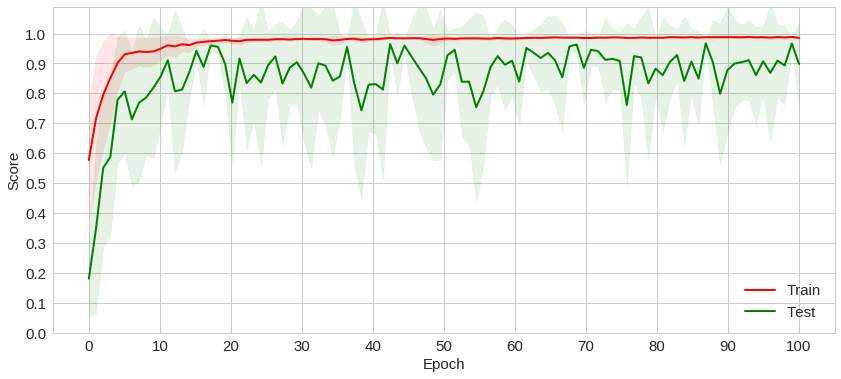

In [28]:
plot_mean_acc(hist)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

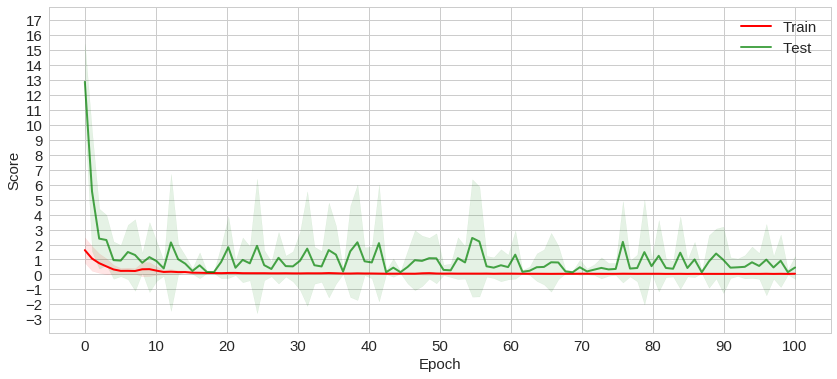

In [30]:
plot_mean_loss(hist)